<a id="Table-Of-Contents"></a>
# Содержание
* [1. Описание задачи.](#Task-Details)
* [2. Описание имеющихся данных, процесса их сбора, подготовки и формирования исходного датасета.](#Data-Analysis)
* [3. Получение временного ряда.](#TS-receive)
    * [3.1 Чтение данных.](#Read-in-Data)
    * [3.2 Описание переменных.](#Feature-Description)
    * [3.3 Подготовка временного ряда.](#TS-Prep)
* [4. Анализ временного ряда.](#TS-Analysis)
    * [4.1 Тренд, сезонность.](#Trend-Season-Cycl)
    * [4.2 Стационарность.](#Stationarity)
* [5. Моделирование и прогнозирование временного ряда.](#TS-Modeling-Forecasting)
    * [5.1 Модель ARIMA.](#ARIMA)
    * [5.2 Применение искусственных нейронных сетей.](#NN)
    * [5.3 Выводы.](#Modeling-Forecasting-Conclusion)
* [6. Выводы по результатам вариантов решения задачи и выбор оптимального варианта.](#TS-Modeling-Forecasting-Conclusion)
* [7. Выводы.](#Conclusion)

<a id="Task-Details"></a>
# 1. Описание задачи

    Прогнозирование продаж — это деятельность руководства компании, направленная на определение предполагаемого объема продукции, который будет продан за установленный период времени с использованием имеющихся ресурсов.
    Прогнозирование продаж способствует своевременному выявлению проблем и помогает в принятии решений, направленных на устранение недостатков. Оно необходимо при распределении ресурсов, при постановке целей и бюджетировании, при планировании найма персонала.
    Цель прогнозирования продаж – описание будущих тенденций на определенный промежуток времени и создание основы для планирования продаж. Прогнозирование подразумевает, что за ним последуют действия по бюджетированию, планированию и воплощению прогнозов в реальность.
    При прогнозировании объема продаж используются определенные методы прогноза. 
    К ним относятся следующие методы:
    - экспертный
    - статистический
    Экспертный метод прогноза продаж - метод исследования, котрый опирается на мнение руководителей, сотрудников компании и предпочтения потенциальных потребителей.
    Статистический метод прогноза продаж - это метод исследования, опирающийся на математические рассчеты, применяемые к данным о продажах прошлых периодов.
    Оба этих метода применяются на практике и, зачастую, результат анализа - прогноз - является компиляцией выводов, полученных при совместном использовании этих методик.

    Целью данной дипломной работы является исследование практической применимости статистического метода прогнозирования объемов продаж и получение прогнозных данных об объеме продаж на требуемый период.
    В работе будут использованы реальные данные о продажах в розничной сети производителя мягкой мебели за несколько лет работы.


* [Содержание](#Table-Of-Contents)

<a id="Data-Analysis"></a>
# 2. Описание имеющихся данных, процесса их сбора, подготовки и формирования исходного датасета

    Исходные данные - это объем продаж в разрезе каждого дня за период 5 лет.
    Информация о продажах накапливается в системе оперативного учета "ПС:Управление мебельной фабрикой", разработанной на базе платформы 1С УПП 8.3.
    С применением встроенных средств информационной системы получен отчет о продажах за период 5 лет, данные выгружены в формате .CSV и сохранены на локальном диске в файле "ts_days.csv".
    Далее, данные загружаются в DataFrame pandas и из них формируется непрерывный временной ряд значений с дискретностью 1 день. Значения продаж в пропущенных днях (2019-01-01) заменены на "0" ввиду того обстоятельства, что пропущенный день - это Новый год, и, как показал анализ предыдущих лет, значение продаж в Новый год исчезающе мало, т.е., стремится к "0".
    Далее, группируем данные по неделям и формируем набор данных "неделя" - "сумма продаж за неделю".
    Таким образом, получен временной ряд по продажам продукции в разрезе недели, который необходимо исследовать и выполнить на его основе прогноз продаж на период 52 недели (1 год).


* [Содержание](#Table-Of-Contents)

<a id="TS-receive"></a>
# 3. Получение временного ряда

<a id="Read-in-Data"></a>
# 3.1 Чтение данных

In [1]:
# система
import os
import sys
import pickle
import warnings

# стандартные библиотеки
import numpy as np
import pandas as pd

# метрика и номализатор
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# статистические мктоды анализа временных рядов
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf

# графика
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# загржаю внешние скрипты
path_to_local_data = os.path.abspath(os.path.relpath(os.getcwd(), start = 'sales_volume_forecasting'))
sys.path.append(path_to_local_data + '/scripts')

# метод Singular Spectrum Analysis (SSA)
from ssa import SSA
# процедуры подготовки временного ряда для обработки с помощью искусственной нейронной сетью
from NN import ts_feature_preparation, lstm_model, model_fit, pict_loss_val_loss
from NN import test_feature_preparation, test_predict, pict_predict, load_model

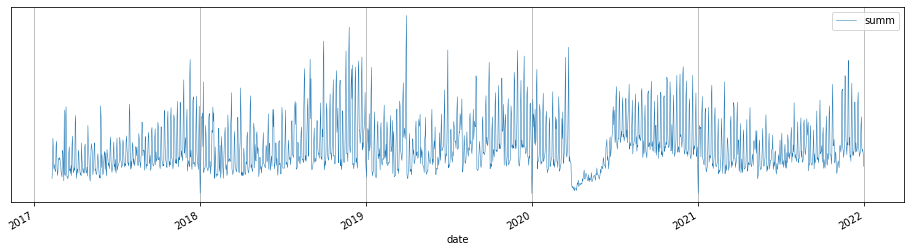

In [3]:
# загружаю данные по продажам
df_CD = pd.read_csv(path_to_local_data + '/data/ts_days.csv', header = None, sep = ';', \
                    skiprows = 520, names = ['date', 'summ'])
# привожу данные к нужным типам
df_CD['date'] = pd.to_datetime(df_CD['date'], format = "%d.%m.%Y")
df_CD['summ'] = df_CD['summ'].astype('float64')
# установливаю дату в качестве индекса
df_CD = df_CD.set_index('date')
# рисую
df_CD.plot(figsize = (16, 4), yticks = [], lw = .5)
plt.grid()
plt.show()

Первые 520 записей пропущены, т.к. они не корректны

* [Содержание](#Table-Of-Contents)

<a id="Feature-Description"></a>
# 3.2 Описание переменных

Получили массив данных "дата"-"сумма продаж" (с 9/02/2017 по 3/02/2022, суммы "по заказам" из 1С)

In [4]:
df_CD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1786 entries, 2017-02-09 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   summ    1786 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


In [5]:
#df_CD.head()

Индекс датасета - дата измерения, "summ" - величина измерения

* [Содержание](#Table-Of-Contents)

<a id="TS-Prep"></a>
# 3.3 Подготовка временного ряда

Нахожу пропущенные даты и присваиваю меткам среднее значение по всему временному ряду

In [6]:
# генерирую синтетический набор от стартовой до конечной даты исходного временного ряда, без пропусков, 
# частота = "день"
timerange = pd.date_range(start = df_CD.index[0], end = df_CD.index[-1], freq = 'D')
# генерирую датасет
df2 = pd.DataFrame(index = timerange)
# объединяю исходный временной ряд с синтетическим
# там, где в исходном ряде пропущены даты, получим пропущенную дату и NaN в столбце "summ"
newdf = df_CD.join(df2, how = 'outer')
print(f'Было пропущено дней: {newdf.shape[0] - df_CD.shape[0]}')
print(f'Пропущенные даты: {newdf[newdf.summ.isna()].index.format()}')

Было пропущено дней: 1
Пропущенные даты: ['2019-01-01']


    Пропущенный день 01/01/2019 является праздничным днем, исторически, объем продаж 01/01 исчезающе мал.
    Т.о., заменим значение продаж в пропущенный день на "0".

In [7]:
# заменяю все NaN на среднее значение по всему временному ряду
df_CD = newdf.fillna(0.0)
df_CD.shape

(1787, 1)

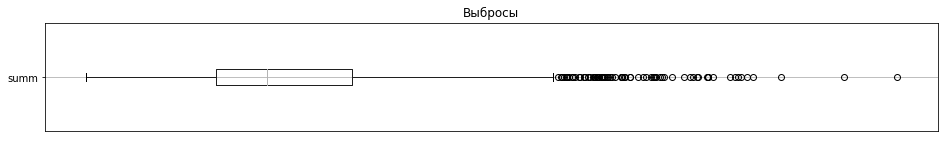

In [8]:
# выбросы
df_CD.boxplot(figsize = (16, 2), vert = False)
plt.title('Выбросы')
plt.xticks([])
plt.show()

    Выбросы в значениях меток присутствуют. Но, учитывая, что это данные, которые используются в регламентированном учете, есть мнение, что данные истинны. Решение - оставляю, как есть.

In [9]:
# итоговый временной ряд для анализа
df_CD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1787 entries, 2017-02-09 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   summ    1787 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


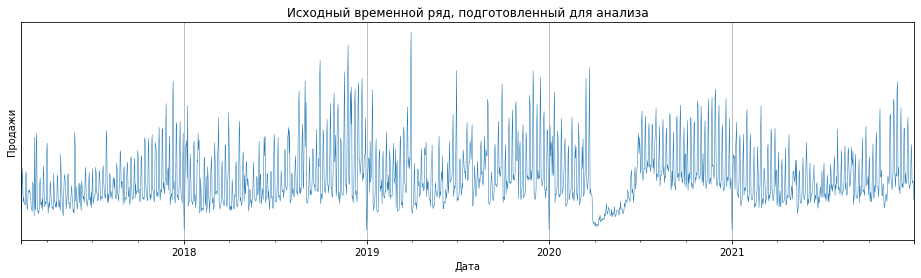

In [10]:
df_CD.plot(figsize = (16, 4), yticks = [], lw = .5, title = 'Исходный временной ряд, подготовленный для анализа', \
           grid = True, xlabel = 'Дата', ylabel = 'Продажи', legend = False)
plt.show()

* [Содержание](#Table-Of-Contents)

<a id="TS-Analysis"></a>
# 4. Анализ временного ряда

    Алгоритм анализа:
    1. из исходного ряда выделяем недельную сезонность, фиксируем
    2. из исходного ряда вычитаем ряд недельной сезонности и выделяем месячную сезонность, фиксируем
    3. из исходного ряда вычитаем ряды недельной и месячной сезонности, выделяем годовую сезонность, фиксируем
    4. из исходного ряда вычитаем все вышеперечисленные компоненты, выделяем тренд и шумы, фиксируем
    5. фиксируем остаток временного ряда после вычета всех вышеперчисленных компонент

<a id="Trend-Season-Cycl"></a>
# 4.1 Тренд, сезонность, шум.

    Для определения характеристик временного ряда воспользуемся методом Singular Spectrum Analysis

In [11]:
# исходный временной ряд с группировкой по неделям
ts = df_CD['summ'].resample('W').sum().values

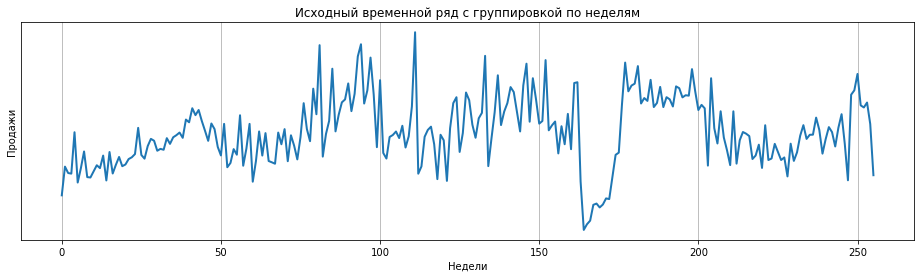

In [12]:
plt.figure(figsize = (16, 4))
plt.plot(ts, lw = 2.)
plt.title('Исходный временной ряд с группировкой по неделям')
plt.xlabel('Недели')
plt.ylabel('Продажи')
plt.yticks([])
plt.grid()
plt.show()

In [13]:
# нормализуем исходный ряд
scaler = MinMaxScaler(feature_range = (0, 1))
ts = scaler.fit_transform(ts.reshape(-1, 1)).reshape(1,-1)[0]
ts.shape

(256,)

In [14]:
# данные составляющих исходного временного ряда
ts_components = {}

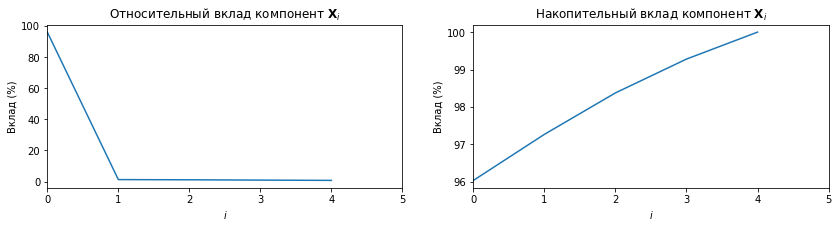

In [15]:
# месячная сезонность
L = 5 # окно анализа
ssa = SSA(L, ts)#ts.values)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components()

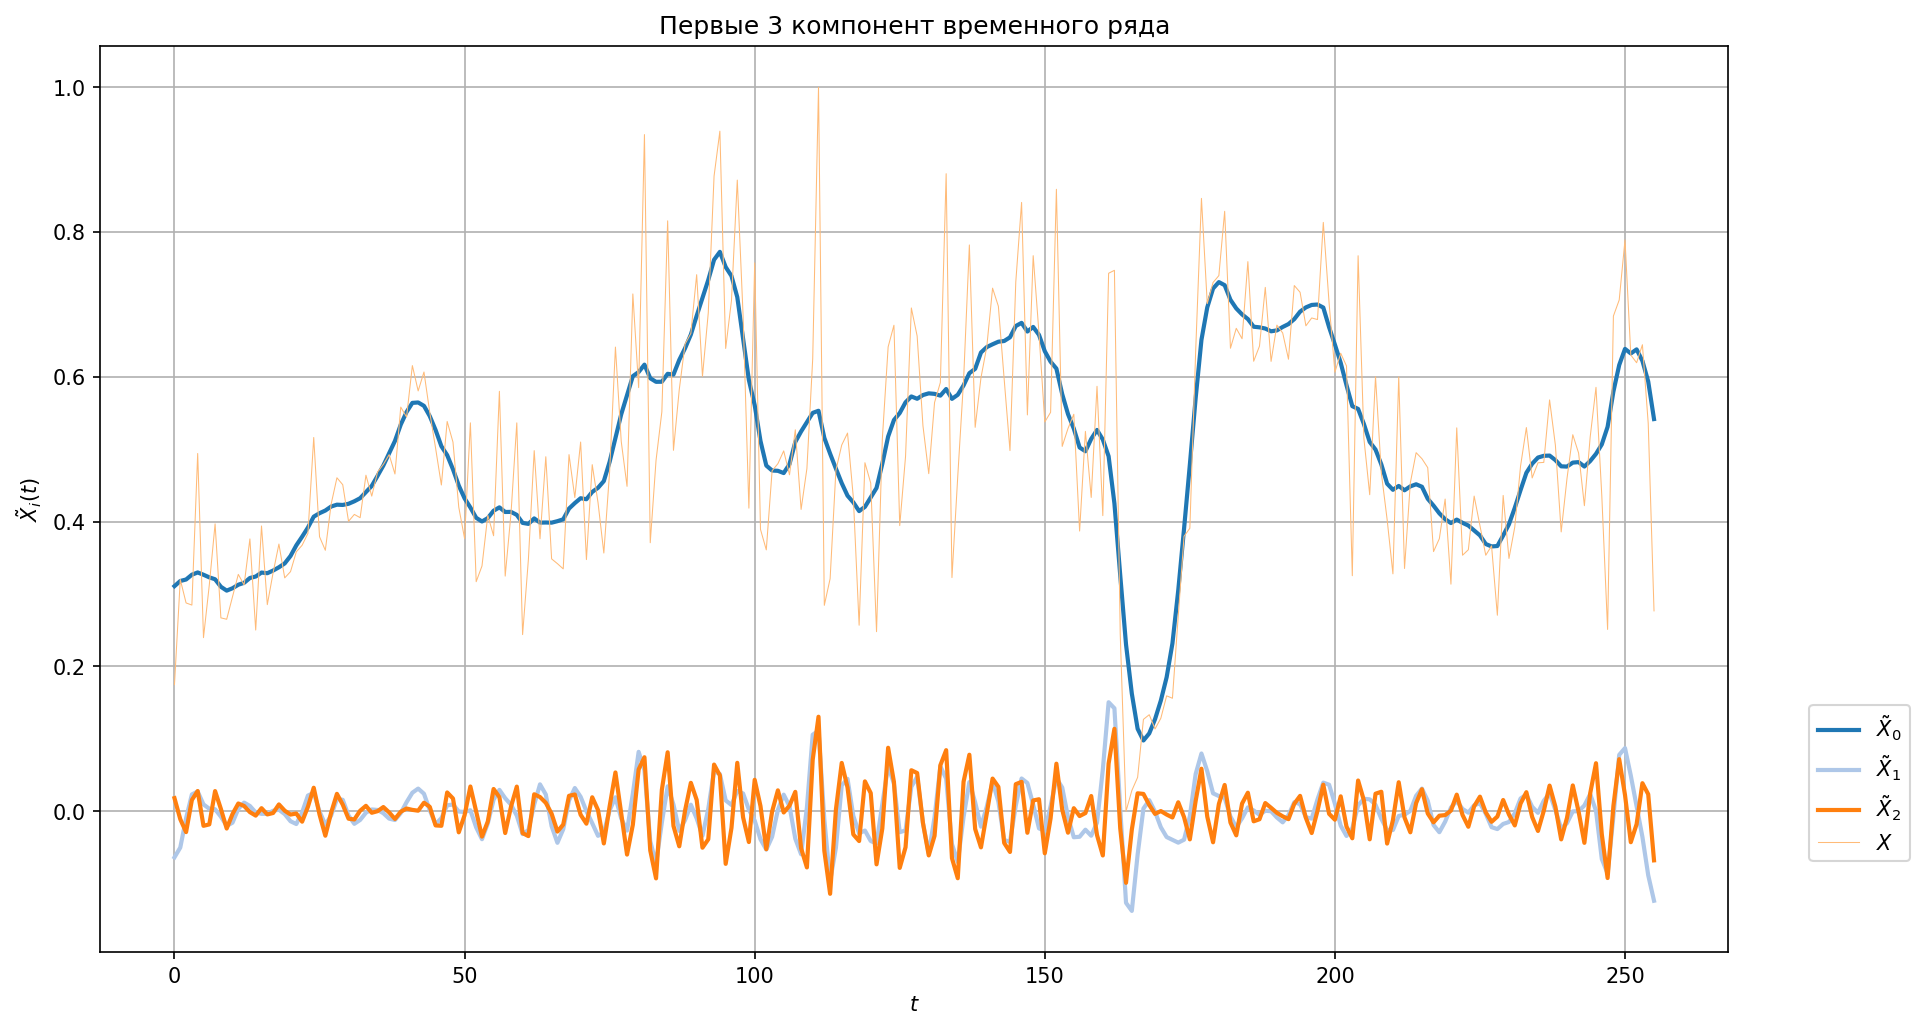

In [16]:
ssa.pict_components(3)

    Наблюдаем Хо локальный тренд, Х1 и Х2 систематические компоненты с цикличностью 1 месяц.

In [17]:
# фиксируем месячные составляющие временного ряда
ts_components['месячная №1'] = {'X' : ssa.Xi_ts[1]} # месячная сезонность №1
ts_components['месячная №2'] = {'X' : ssa.Xi_ts[2]} # месячная сезонность №2

In [18]:
def ts_subtracting_components(ts, ts_components):
    """ Вычитает из исходного ряда все выделенные компоненты """
    
    for key in ts_components.keys():
        ts = ts - ts_components[key]['X']
    
    return ts

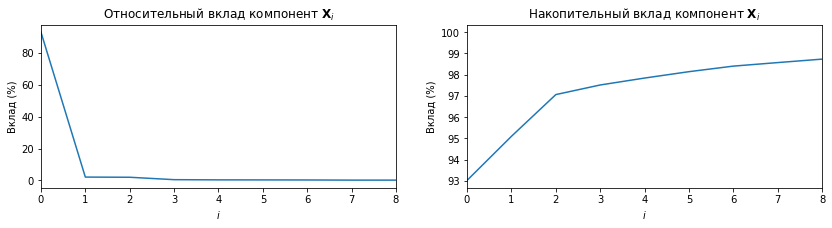

In [19]:
# сезонность с периодичностью 1 год
# из исходного ряда вычитаем месячную сезонность
_ts = ts_subtracting_components(ts, ts_components)

# выделяем годовую сезонность
L = 52
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

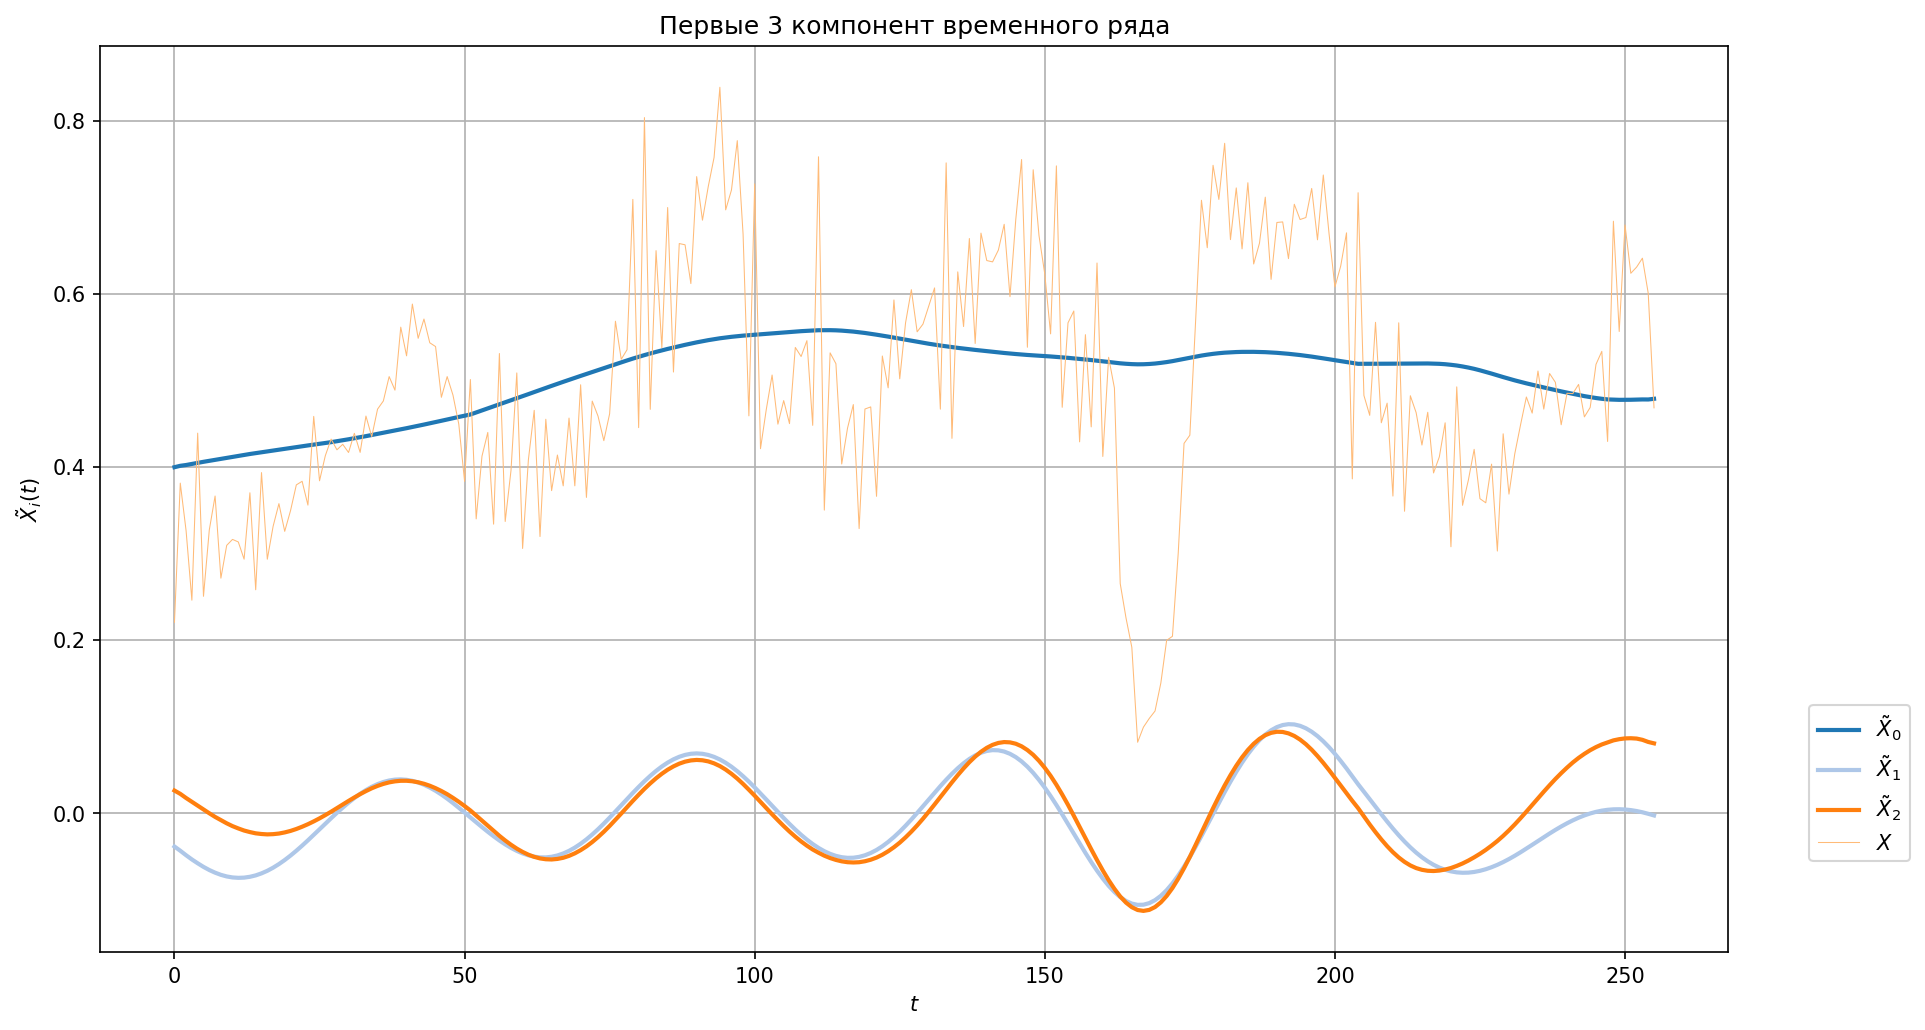

In [20]:
ssa.pict_components(3)

    Наблюдаем компоненты Х1 и Х2 годовой периодичности.

In [21]:
# фиксируем годовые составляющие временного ряда
ts_components['годовая №1'] = {'X' : ssa.Xi_ts[1]} # годовая сезонность №1
ts_components['годовая №2'] = {'X' : ssa.Xi_ts[2]} # годовая сезонность №2

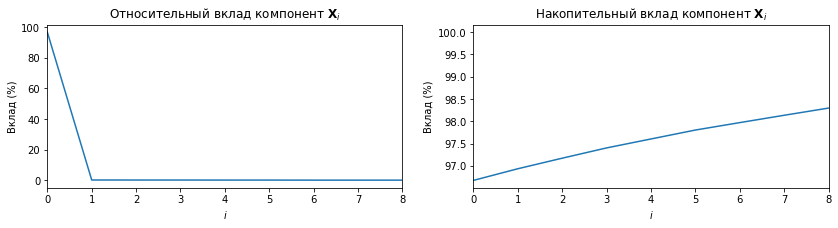

In [22]:
# 4 месячная сезонность
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем 4 месячную сезонность
L = 104
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

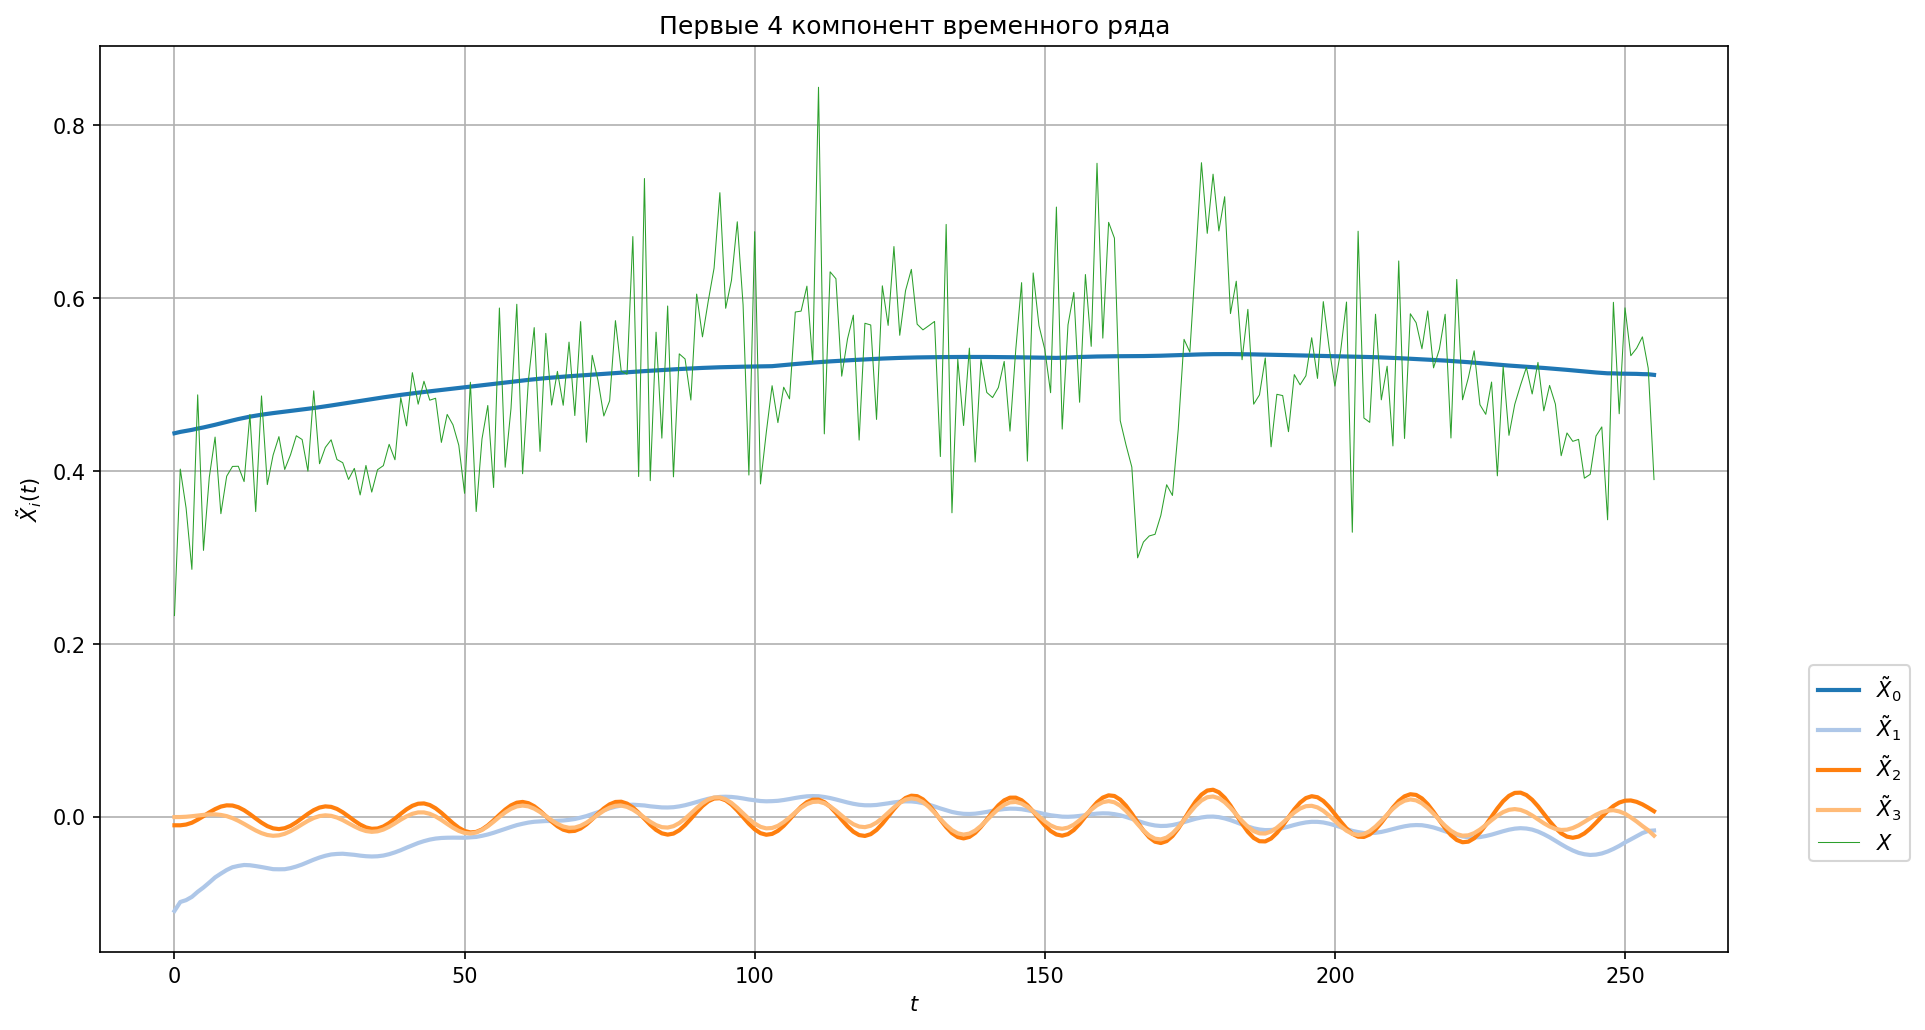

In [23]:
ssa.pict_components(4)

    Наблюдаем компоненты Х2 и Х3 - 4 месячной периодичности.

In [24]:
# фиксируем 4 месячные составляющие временного ряда
ts_components['4 месячная №1'] = {'X' : ssa.Xi_ts[2]} # 4 месячная сезонность №1
ts_components['4 месячная №2'] = {'X' : ssa.Xi_ts[3]} # 4 месячная сезонность №2

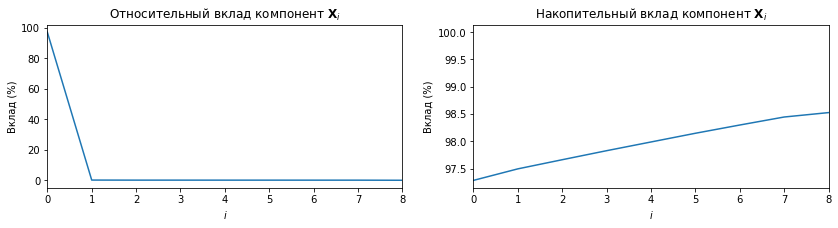

In [25]:
# полугодовая сезонность
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем полугодовую сезонность
L = 104
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

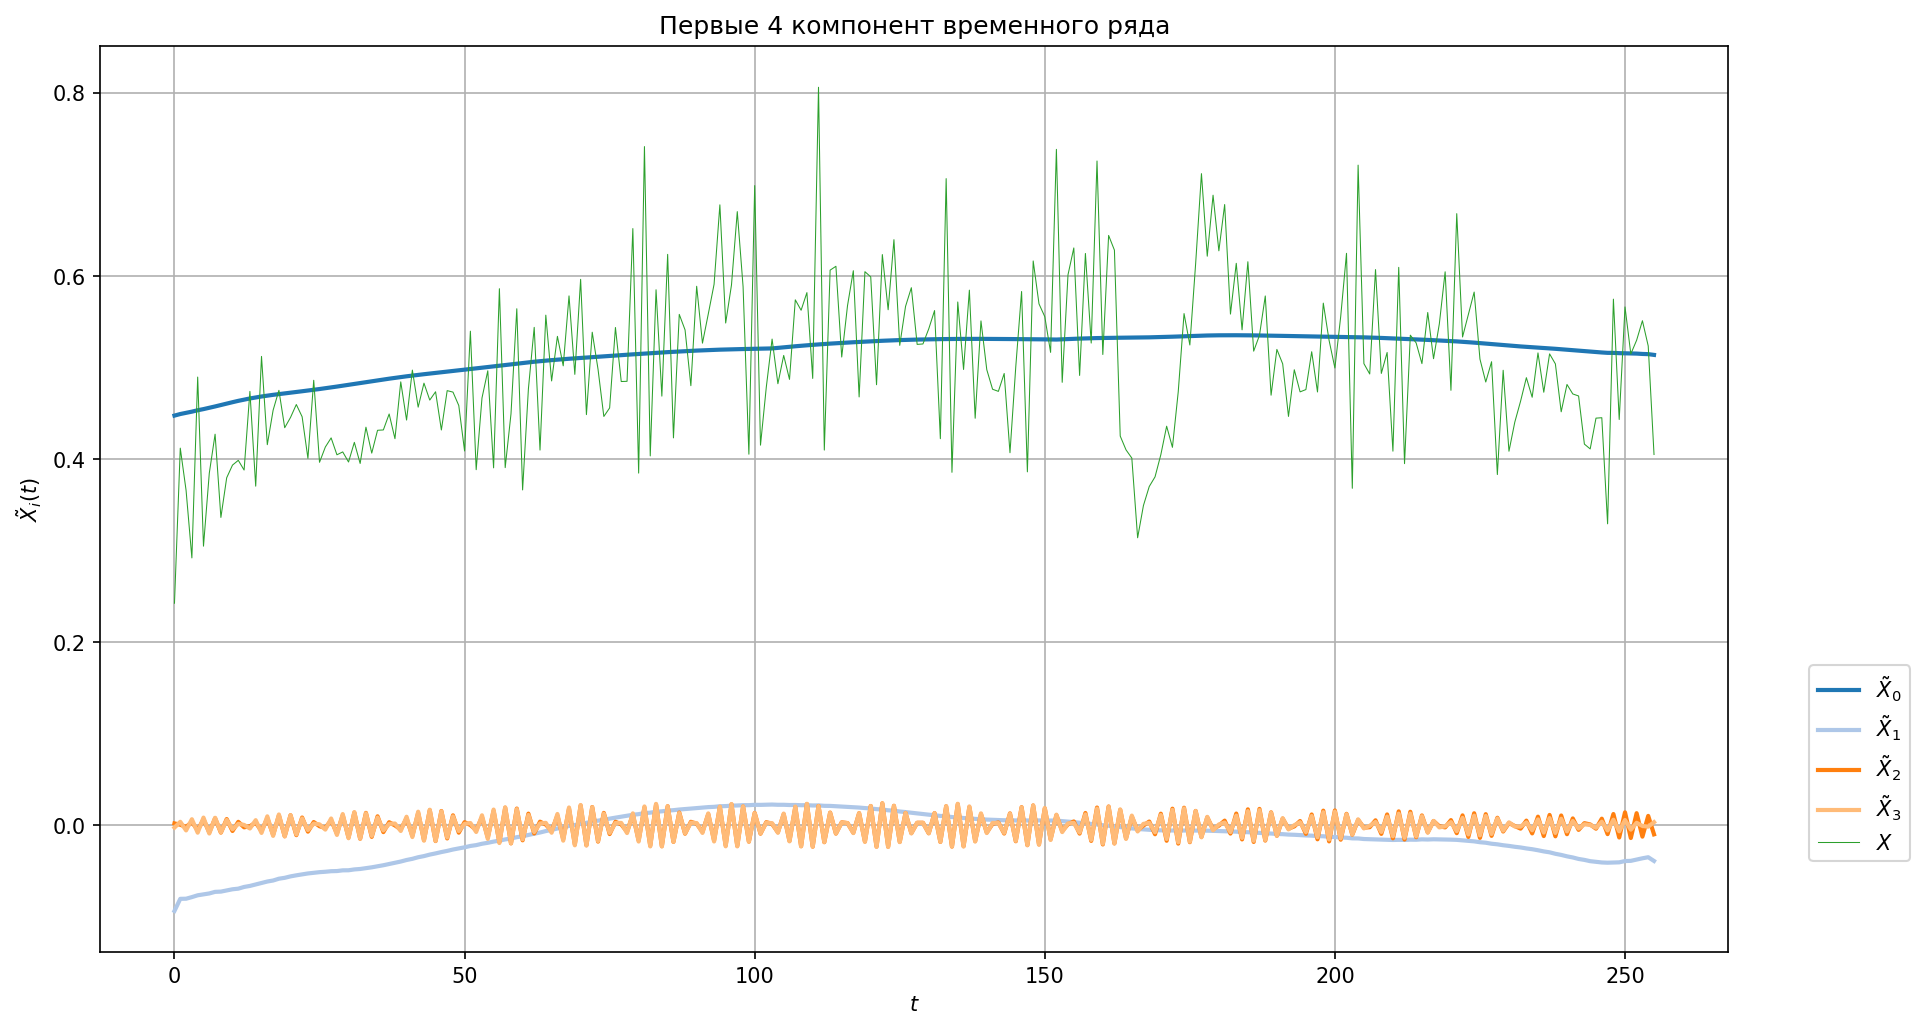

In [26]:
ssa.pict_components(4)

    Наблюдаем компоненты Х2 и Х3 с периодичностью полгода.

In [27]:
# фиксируем полугодовые составляющие временного ряда
ts_components['полугодовая №1'] = {'X' : ssa.Xi_ts[2]} # полугодовая сезонность №1
ts_components['полугодовая №2'] = {'X' : ssa.Xi_ts[3]} # полугодовая сезонность №2

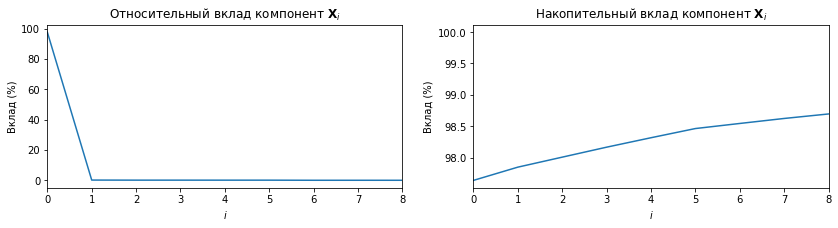

In [28]:
# квартальная сезонность
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем квартальную сезонность
L = 104
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

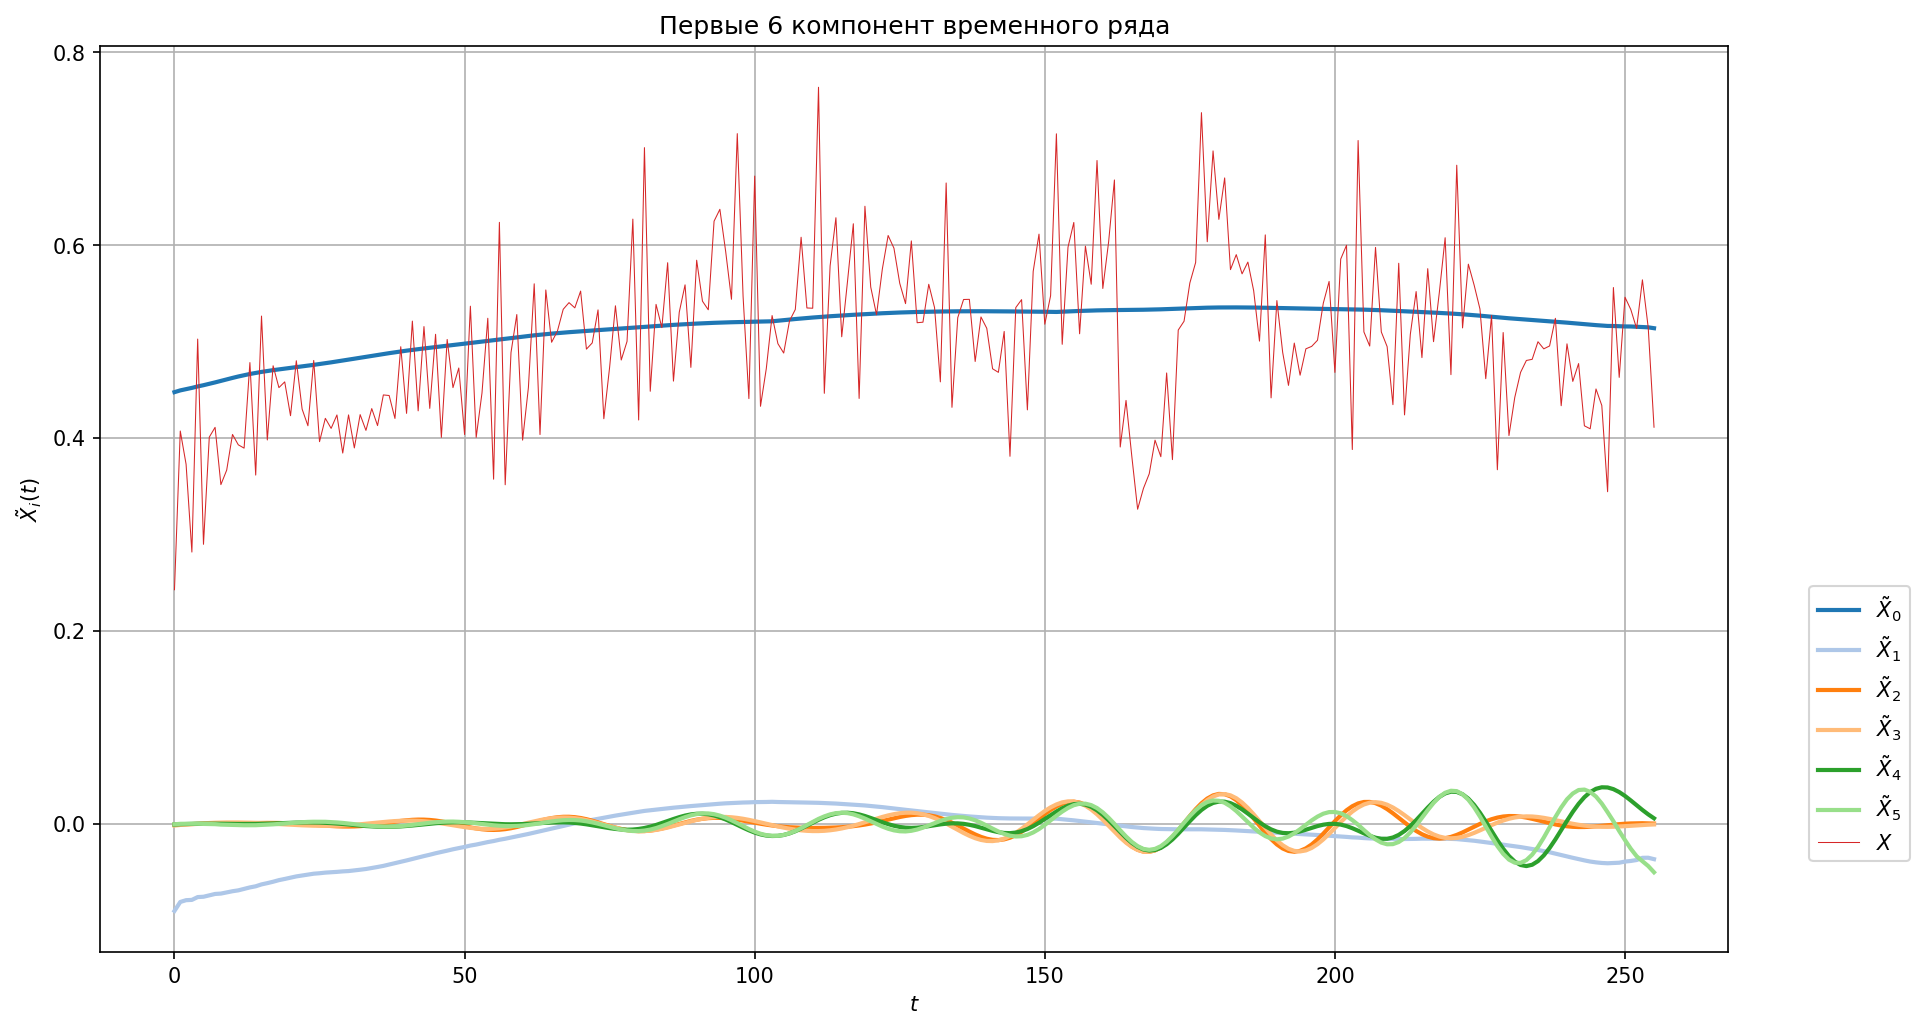

In [29]:
ssa.pict_components(6)

    Наблюдаем компоненты Х4 и Х5 квартальной сезонности.

In [30]:
# фиксируем квартальные составляющие временного ряда
ts_components['квартальная №1'] = {'X' : ssa.Xi_ts[4]} # квартальная сезонность №1
ts_components['квартальная №2'] = {'X' : ssa.Xi_ts[5]} # квартальная сезонность №2

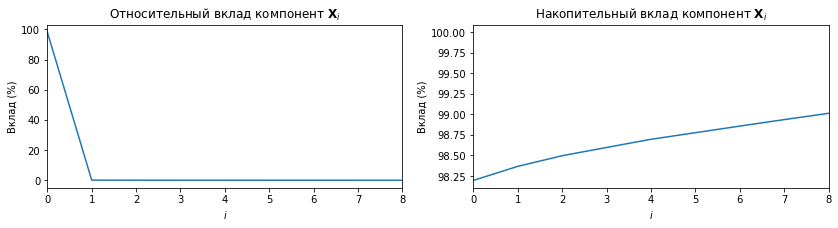

In [31]:
# квартальная цикличность
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем квартальную цикличность
L = 52
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

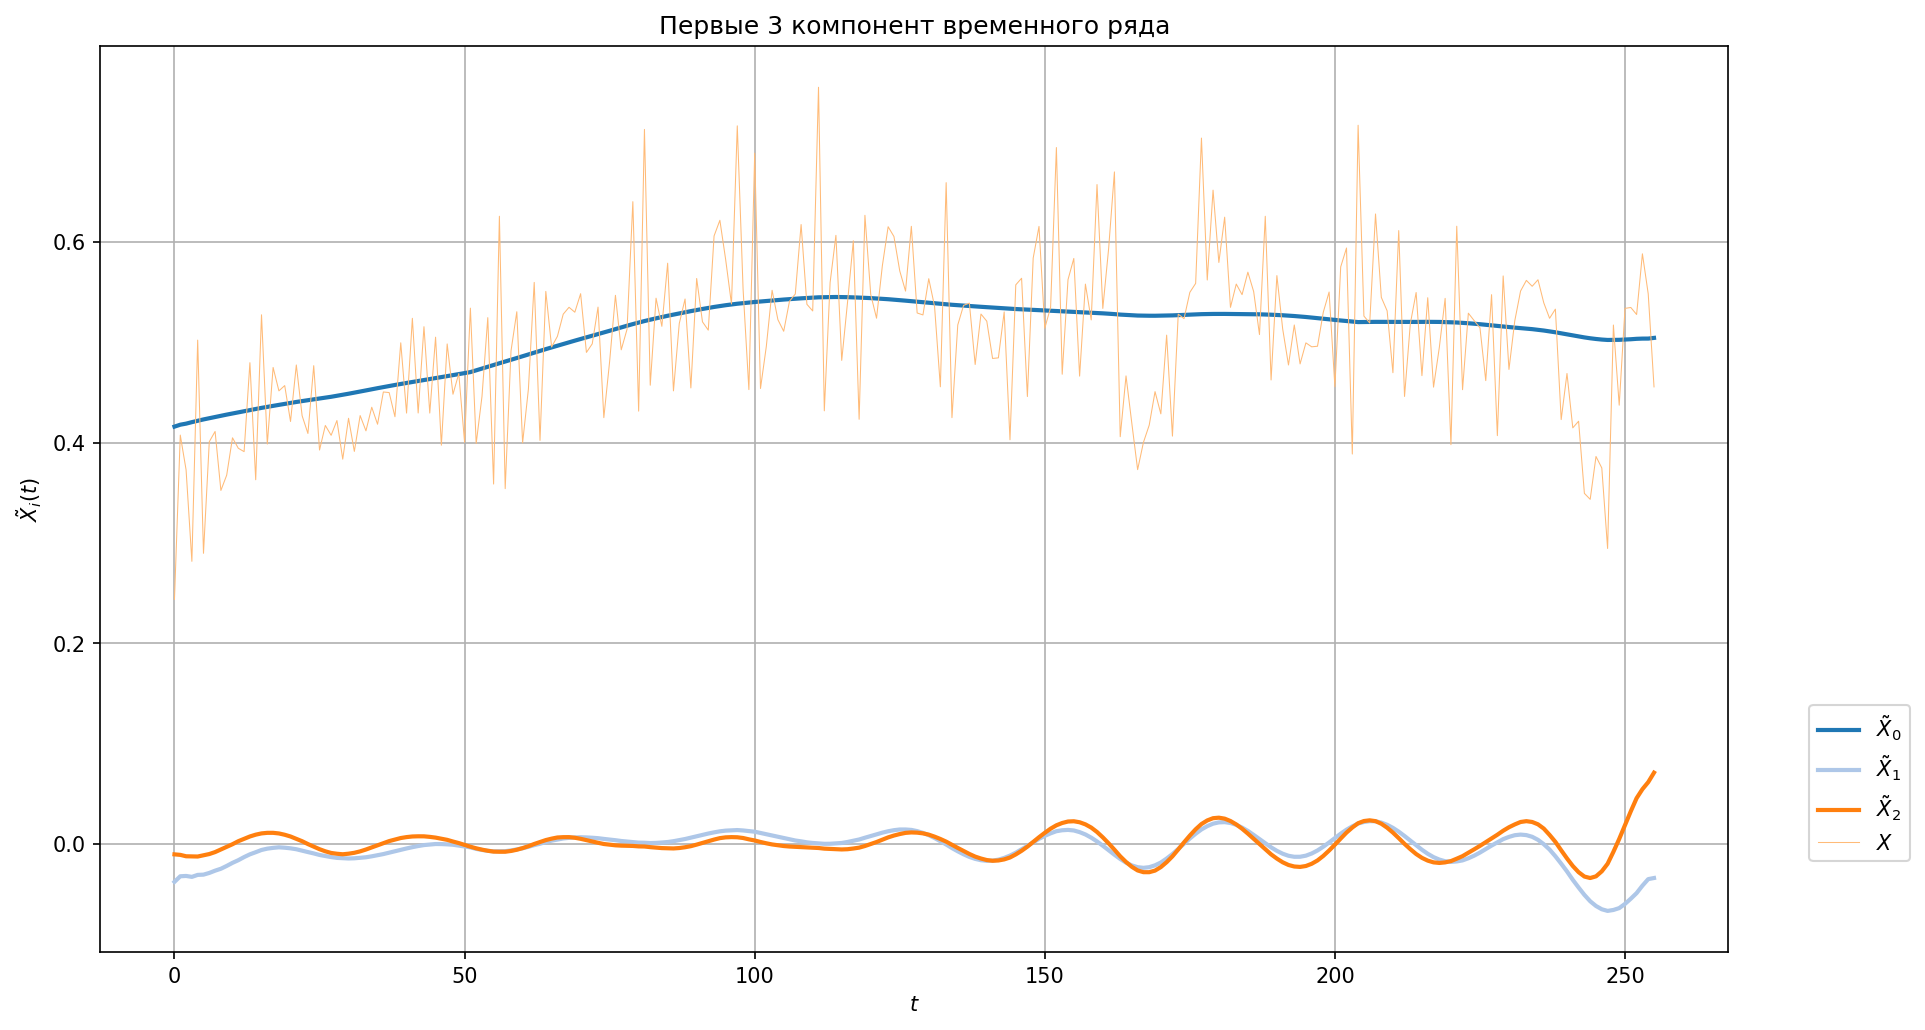

In [32]:
ssa.pict_components(3)

    Наблюдаем компоненты Х1 и Х2 с недельной сезонностью и квартальной цикличностью.

In [33]:
# фиксируем составляющие временного ряда
ts_components['квартальная №3'] = {'X' : ssa.Xi_ts[1]} # квартальная цикличность №1
ts_components['квартальная №4'] = {'X' : ssa.Xi_ts[2]} # квартальная цикличность №2

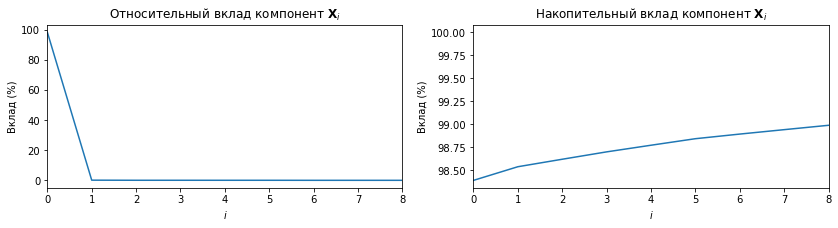

In [34]:
# непонятная компонента
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем непонятную компоненту - похожа по форме на тренд
L = 104
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

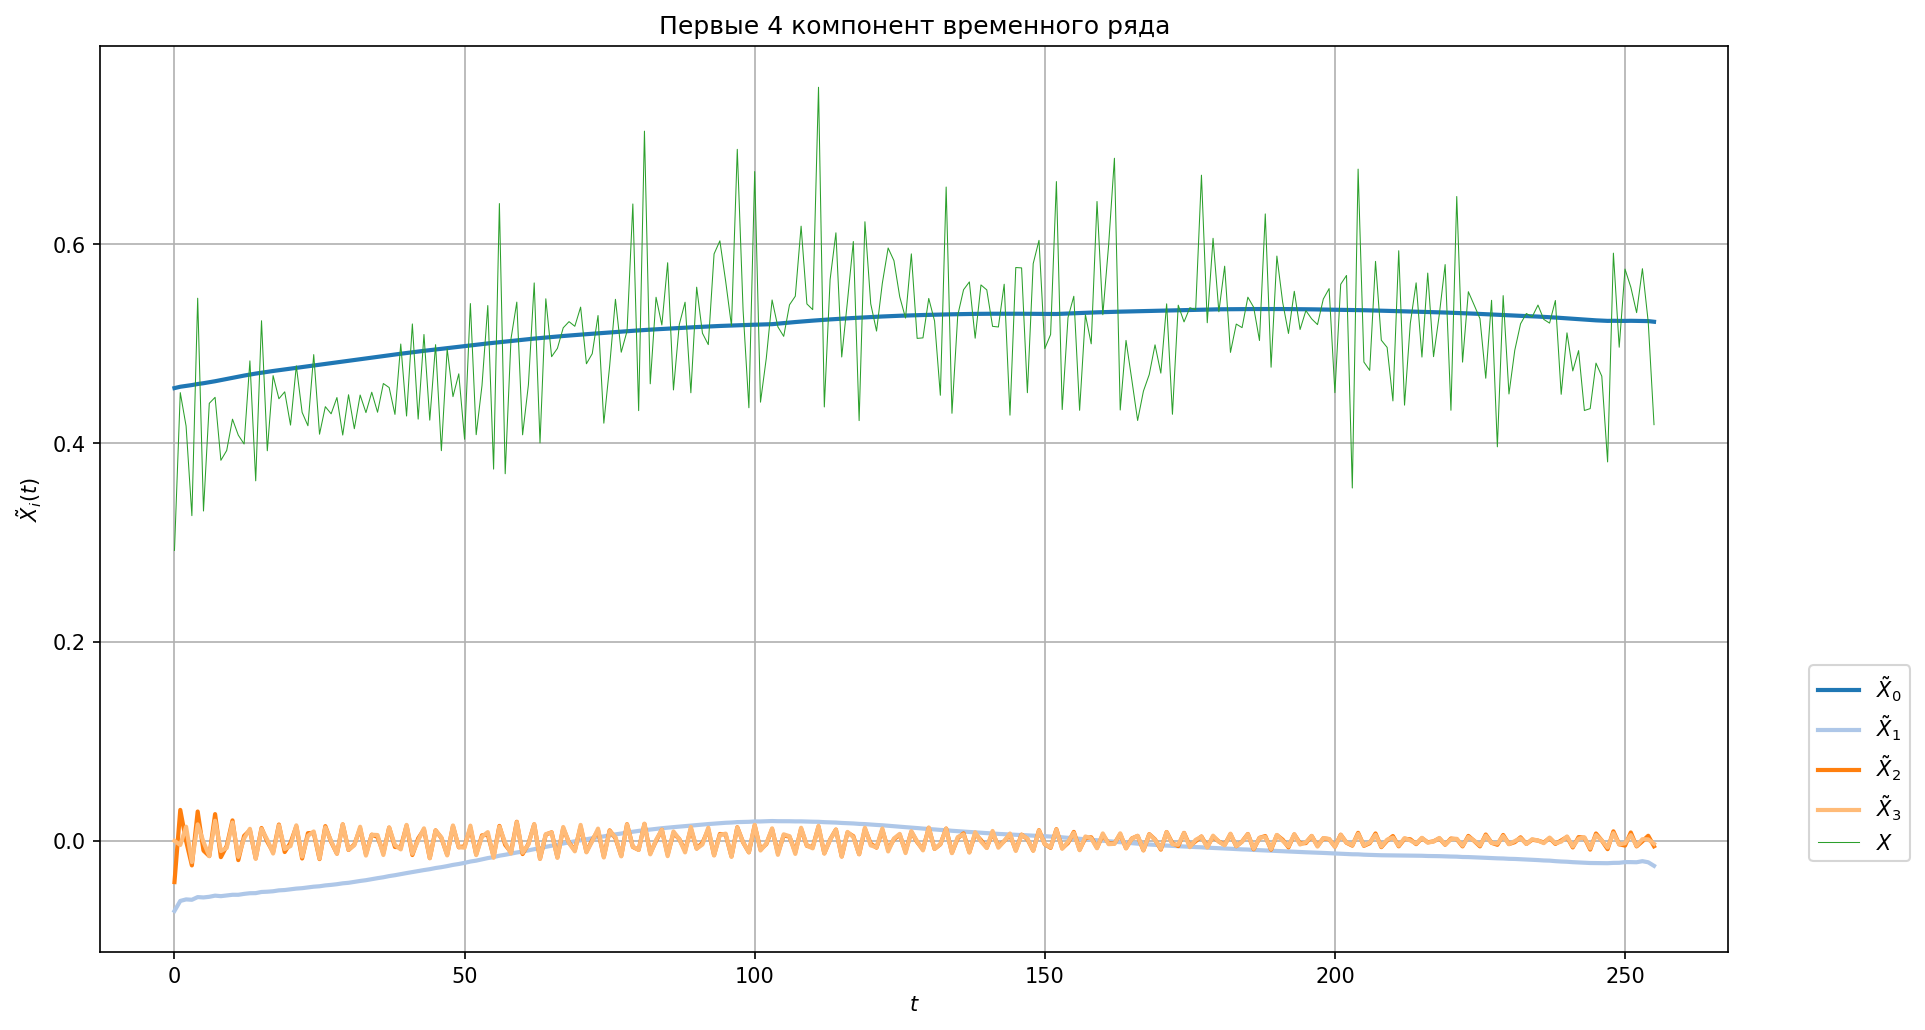

In [35]:
ssa.pict_components(4)

In [36]:
# фиксируем составляющие временного ряда
ts_components['непонятная'] = {'X' : ssa.Xi_ts[1]} # непонятная компонента

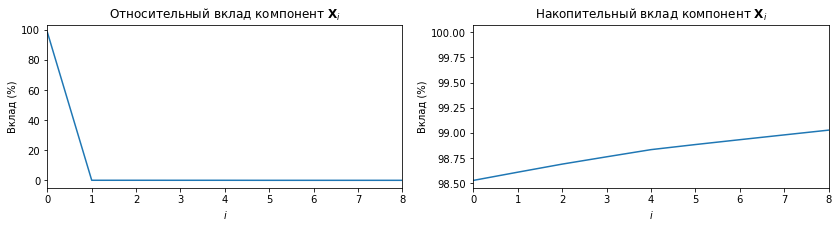

In [37]:
# тренд и шум
# из исходного ряда вычитаем ранее определенные сезонности
_ts = ts_subtracting_components(ts, ts_components)

# выделяем тренд и шум
L = 104
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

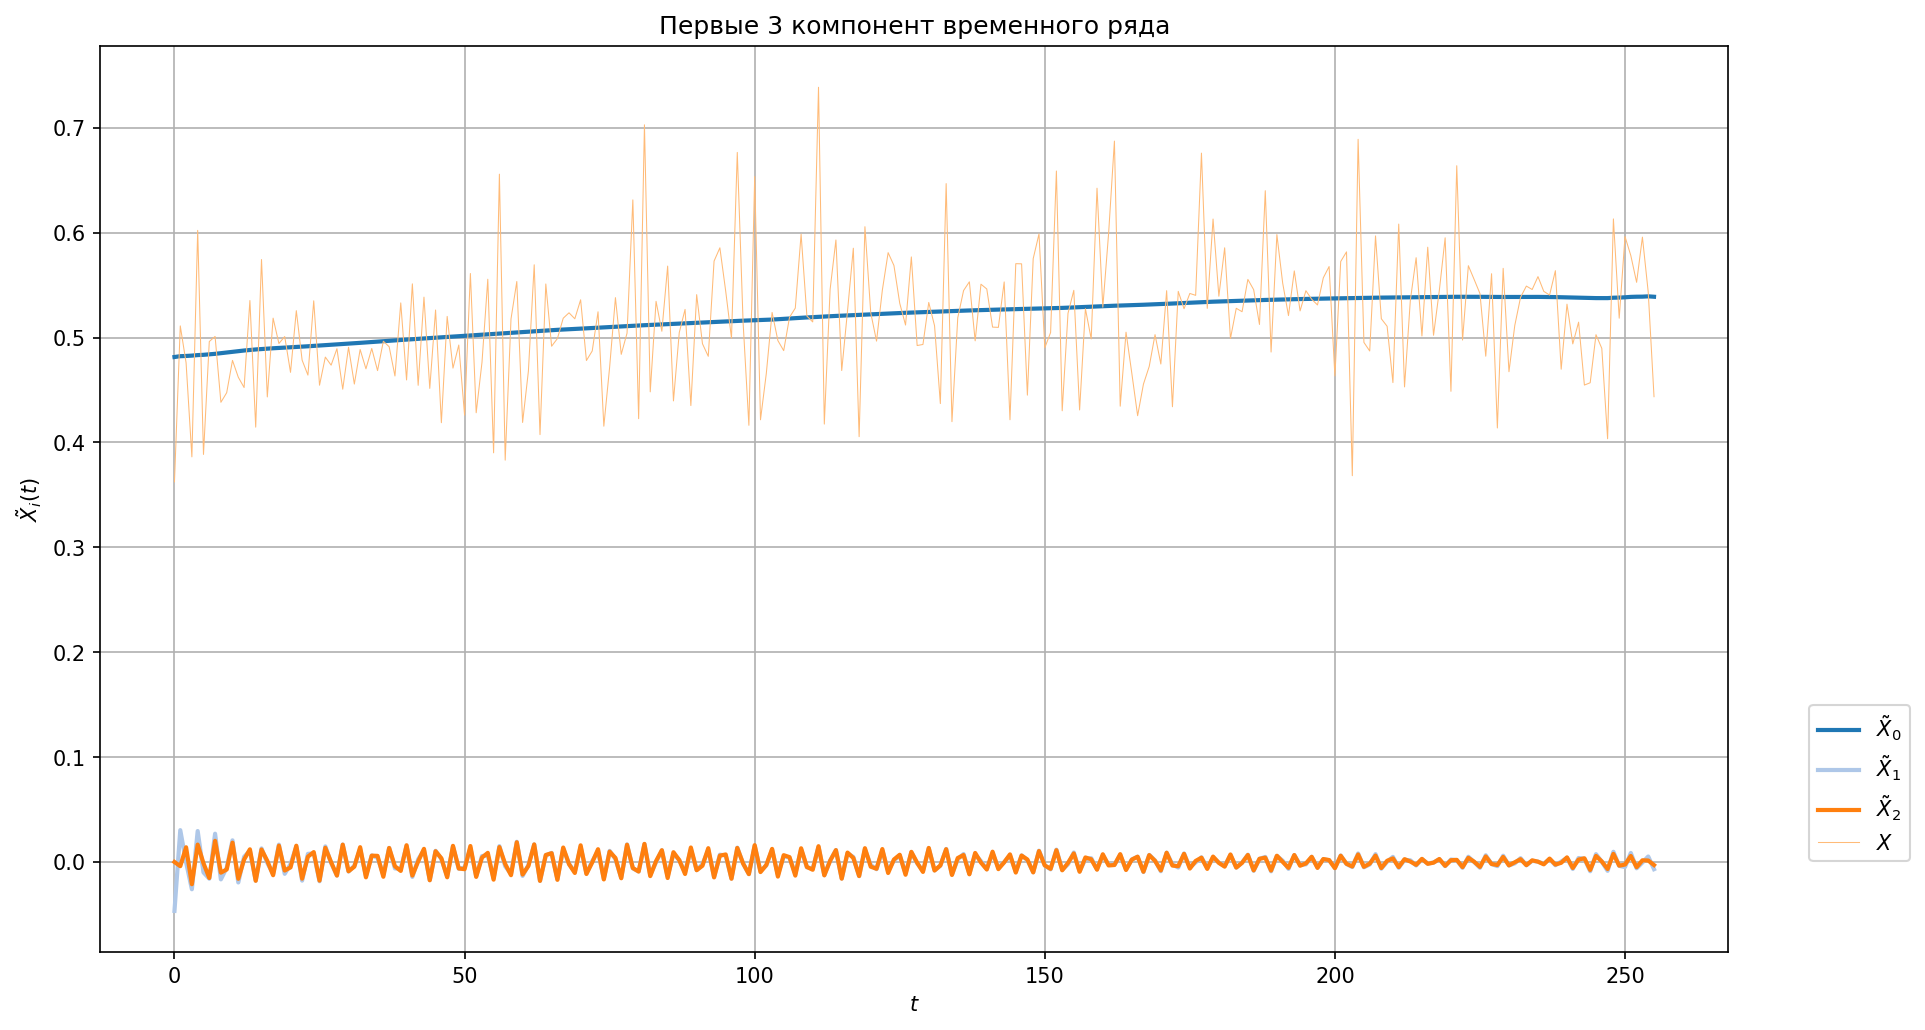

In [38]:
ssa.pict_components(3)

In [39]:
# фиксируем составляющие временного ряда
ts_components['тренд'] = {'X' : ssa.Xi_ts[0]} # тренд
ts_components['шум №1'] = {'X' : ssa.Xi_ts[1]} # шум №1
ts_components['шум №2'] = {'X' : ssa.Xi_ts[1]} # шум №2

In [40]:
# фиксируем остаток "исходный ряд 'минус' сумма всех компонент"
ts_components['остаток'] = {'X' : ts_subtracting_components(ts, ts_components)}

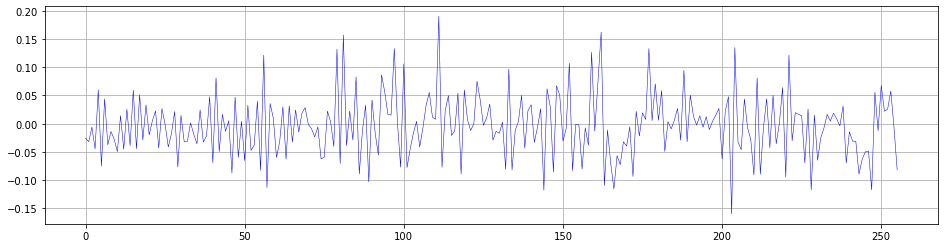

In [41]:
# рисую остатки
plt.figure(figsize=(16, 4))
plt.plot(ts_components['остаток']['X'], color='blue', lw = .5)
plt.grid()
plt.show()

    Выводы:
    1. исследуемый временной ряд имеет недельную, месячную и годовую цикличности
    2. тренд прослеживается слабо - начало и конец компоненты тренда практически на одном уровне
    3. наблюдаются большое количество шумовых компонент
    4. методом Singular Spectrum Analysis было выделено 16 компонент (2 месячных, 2 годовых, 2 4-х месячных, 2 полугодовых, 4 квартальных, 2 шумовых, тренд) и остаток от вычитания из исходного ряда выделенных 16 компонент

* [Содержание](#Table-Of-Contents)

<a id="Stationarity"></a>
# 4.2 Стационарность.

    Проверю ряд на стационарность, т.е. попытаюсь понять, насколько поведение ряда устойчиво во времени:
    1. построю график скользящего среднего и скользящего стандартного отклонения
    2. проведу тест Дики-Фуллера (ADF)

In [42]:
def test_stationarity(ts):
    """ Проверка стационарности временного ряда """
    
    # построю график скользящего среднего и скользящего стандартного отклонения
    plt.figure(figsize = (16, 4))
    plt.plot(pd.DataFrame(ts), color = 'blue', label = 'истинные значения')
    plt.plot(pd.DataFrame(ts).rolling(window = 52).mean(), color = 'red', label = 'скользящее среднее')
    plt.plot(pd.DataFrame(ts).rolling(window = 52).std(), color = 'orange', label = 'скользящее стд.отклонение')
    plt.title('Скользящее среднее и стандартное отклонение')
    plt.xlabel('Наблюдение')
    plt.ylabel('Нормализованное значение')
    plt.grid()
    plt.legend()
    plt.show()
    
    # проведу тест Дики-Фуллера (ADF)
    result = adfuller(ts)
    print(f'ADF-статистика: {result[0]}')
    print(f'P-значение: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')

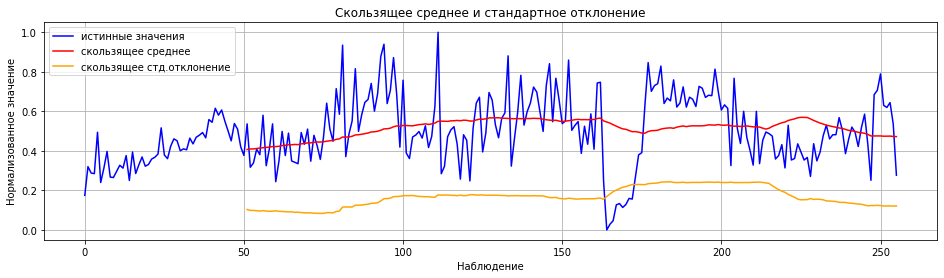

ADF-статистика: -3.5667047367588927
P-значение: 0.006430409641046229
Критические значения:
  1%: -3.4565688966099373
  5%: -2.8730786194395455
  10%: -2.5729189953388762


In [43]:
# исходный временной ряд
test_stationarity(ts)

    Наблюдаем, что скользящее среднее и стандартное отклонение приблизительно горизонтальны. P-значение ниже порога 0,05, а статистика ADF близка к критическим значениям. Следовательно, временной ряд стационарен.

* [Содержание](#Table-Of-Contents)

<a id="TS-Modeling-Forecasting"></a>
# 5. Моделирование и прогнозирование временного ряда

<a id="ARIMA"></a>
# 5.1. Модель ARIMA

    Для моделирования будем использовать модель ARIMA.
    Чтобы построить модель нам нужно знать ее порядок, состоящий из 3-х параметров:
        p — порядок компоненты AR
        d — порядок интегрированного ряда
        q — порядок компонетны MA
    Параметр d есть и он равет 0 (ряд стационарный), осталось определить p и q. 
    Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
    ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
    PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

In [44]:
# глубина прогноза
n_predictions = 12

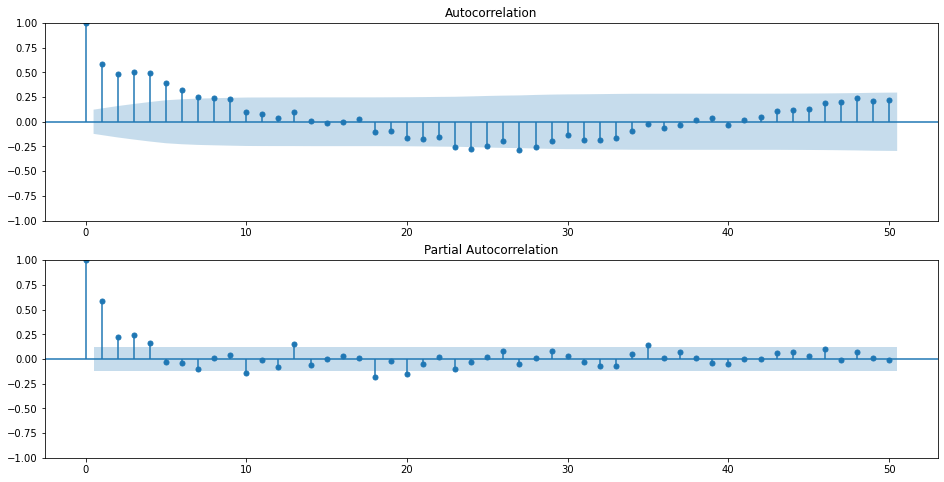

In [45]:
# автокорреляция и частичная автокорреляция
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts, lags = 50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts, lags = 50, method='ywm', ax=ax2)

In [46]:
# параметры модели ARIMA
p = 4  # график PACF показывает 4 значимых лага
d = 0  # стационарный ряд
q = 6  # график ACF показывает 6 знаимых лагов

In [47]:
%%time

# обучаю модель
ARIMA_result = ARIMA(ts, order=(p, d, q)).fit()

CPU times: user 1.4 s, sys: 868 ms, total: 2.26 s
Wall time: 336 ms


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
print(ARIMA_result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(4, 0, 6)   Log Likelihood                 162.905
Date:                Sat, 28 May 2022   AIC                           -301.811
Time:                        19:47:24   BIC                           -259.268
Sample:                             0   HQIC                          -284.700
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4880      0.036     13.747      0.000       0.418       0.558
ar.L1          0.1356      0.178      0.764      0.445      -0.212       0.484
ar.L2         -0.1199      0.188     -0.636      0.5

    Все коэффициенты модели значимы - нет исчезающе малых коэффициентов.

In [49]:
# проверю остатки данной модели на соответствие «белому шуму», а также проанализирую коррелограму остатков
q_test = acf(ARIMA_result.resid, qstat = True)
print(pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]}))

       Q-stat   p-value
0    0.033047  0.855749
1    0.095337  0.953450
2    0.135908  0.987205
3    0.526048  0.970916
4    0.901276  0.970129
5    2.759396  0.838382
6    2.777930  0.904758
7    2.889851  0.941079
8    3.393348  0.946642
9    4.651426  0.913215
10   4.694590  0.945051
11  10.359319  0.584470
12  10.823668  0.625587
13  11.347884  0.658517
14  12.094297  0.671878
15  12.813522  0.686340
16  15.605187  0.551976
17  19.150489  0.382612
18  20.725075  0.352189
19  20.947152  0.400249
20  23.951241  0.295427
21  23.968930  0.348860
22  26.296107  0.287088
23  27.107198  0.299481


    P-значение больше порога в 0.05, поэтому предполагю, что остатки нестационарны, т.е. похожи на случайные значения или "белый шум".

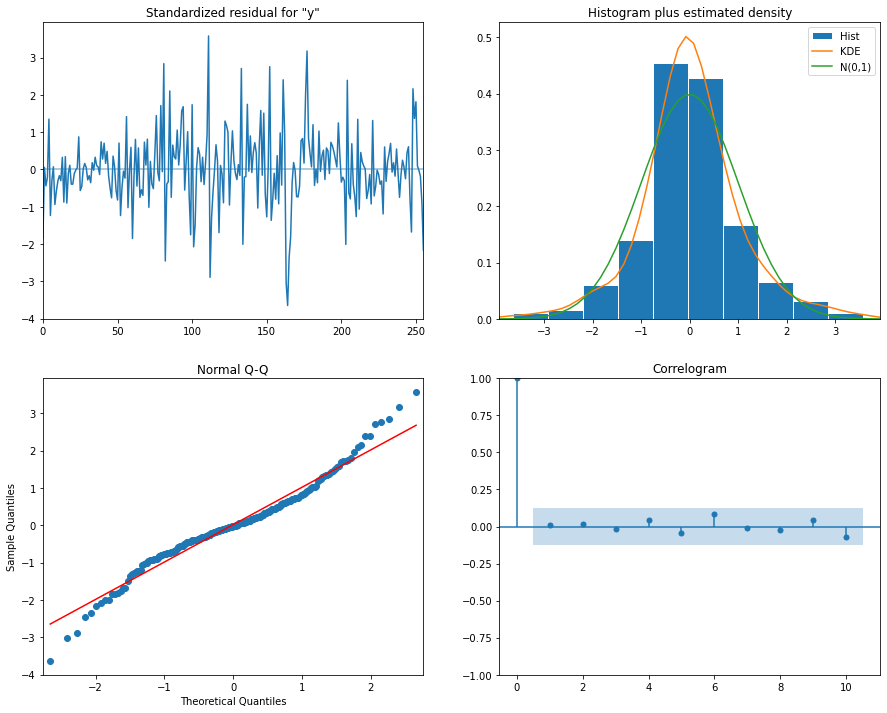

In [50]:
ARIMA_result.plot_diagnostics(figsize = (15, 12))
plt.show()

    Остатки модели распределены с нулевым средним, о чем говорит близость линии KDE к линии нормального распределения N (среднее 0 и стандартное отклонение 1).
    Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

In [51]:
# строю прогноз
pred = ARIMA_result.predict(len(ts) - n_predictions, len(ts) - 1)

In [52]:
# считаю ошибки прогноза
error = [ts[-n_predictions + i] - pred[i] for i in range(n_predictions)]

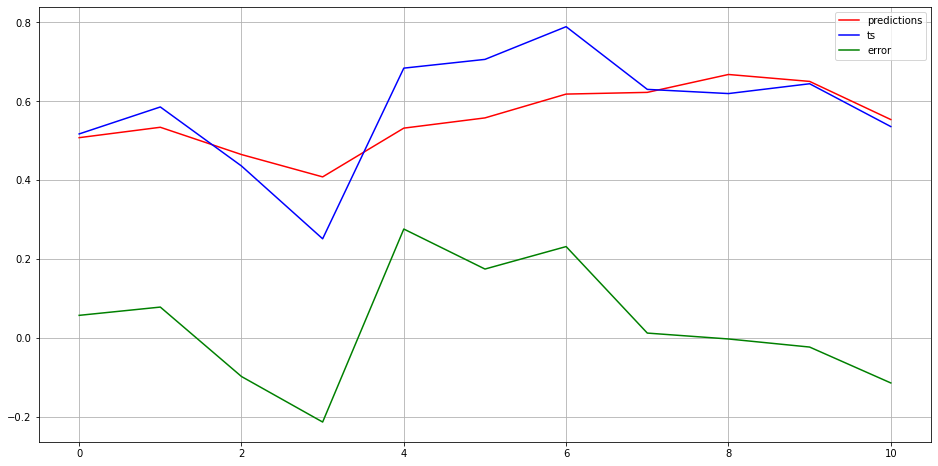

In [53]:
# рисую
plt.figure(figsize=(16,8))
plt.plot(pred[1:], color='red', label='predictions')
plt.plot(ts[-n_predictions:-1], color='blue', label='ts')
plt.plot(error[:-1], color='green', label='error')
plt.grid()
plt.legend()
plt.show()

In [54]:
# метрики качества модели и прогноза 
print('R^2: %1.2f' % r2_score(ts[-n_predictions:-1], pred[1:]))
print(f'sqrt(MSE) на норм. данных: {np.sqrt(mean_squared_error(ts[-n_predictions:-1], pred[1:]))}')

R^2: 0.51
sqrt(MSE) на норм. данных: 0.09789159821334299


    Учитывая полученное значение коэффициента детерминации, можно сказать, что модель объясняет 51% дисперсии значений временного ряда.
    Ошибка на нормализованных данных временного ряда находится в пределах 10% (показатель RMSE = 0,098).

/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


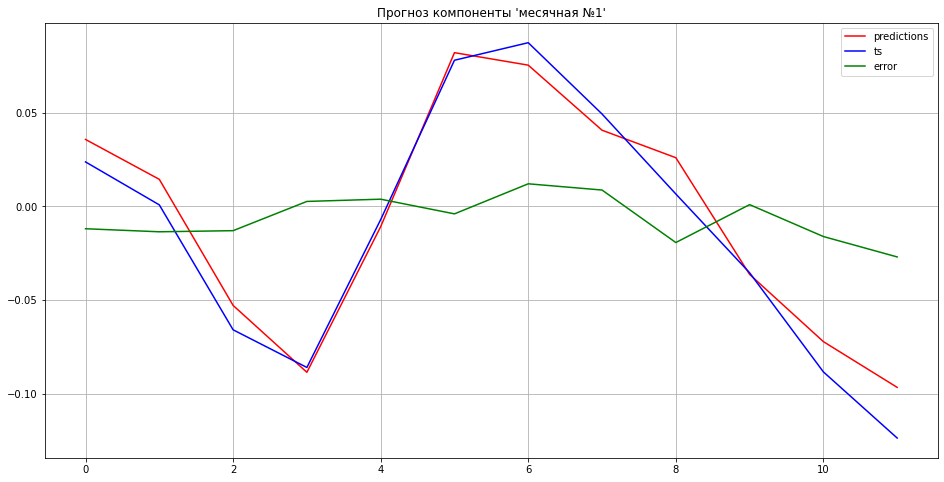

/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


R^2: 0.96
RMSE на норм.данных: 0.013291850567245281


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


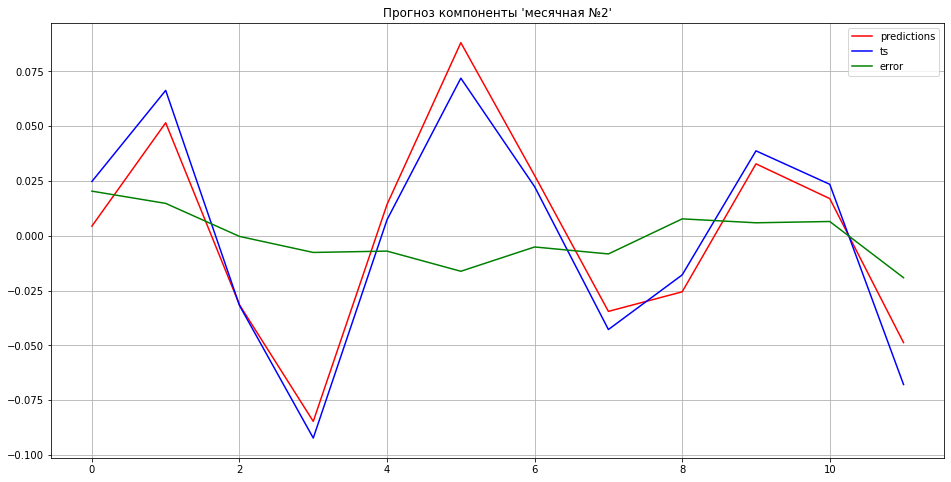

R^2: 0.94
RMSE на норм.данных: 0.011542366292429933


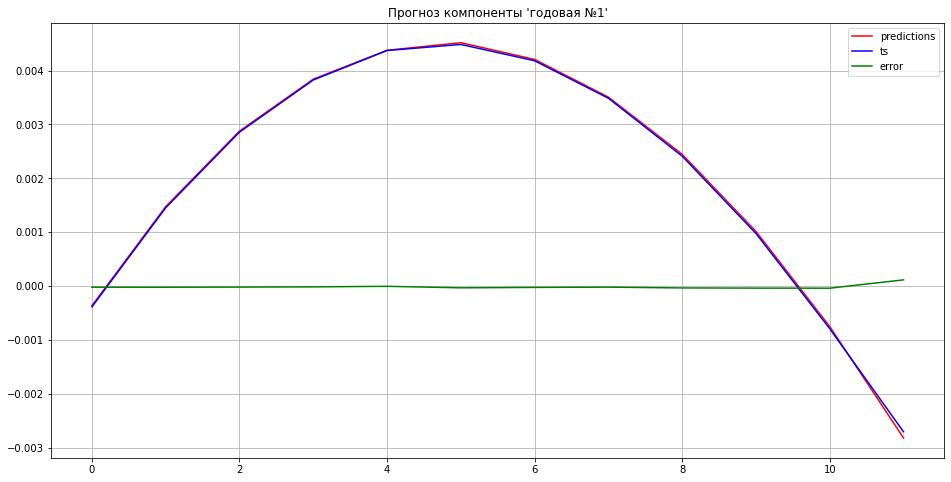

R^2: 1.00
RMSE на норм.данных: 4.1867673275344375e-05


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


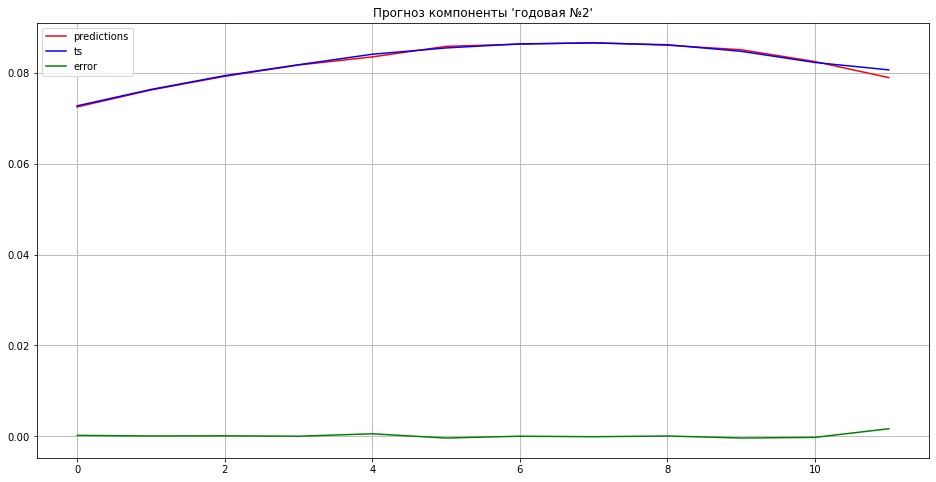

R^2: 0.98
RMSE на норм.данных: 0.0005487216277145287


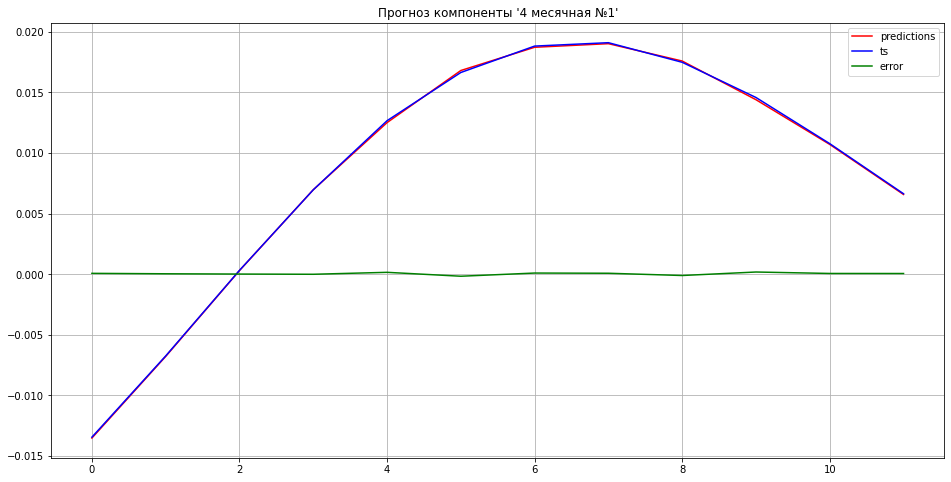

R^2: 1.00
RMSE на норм.данных: 0.00010293869470344593


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


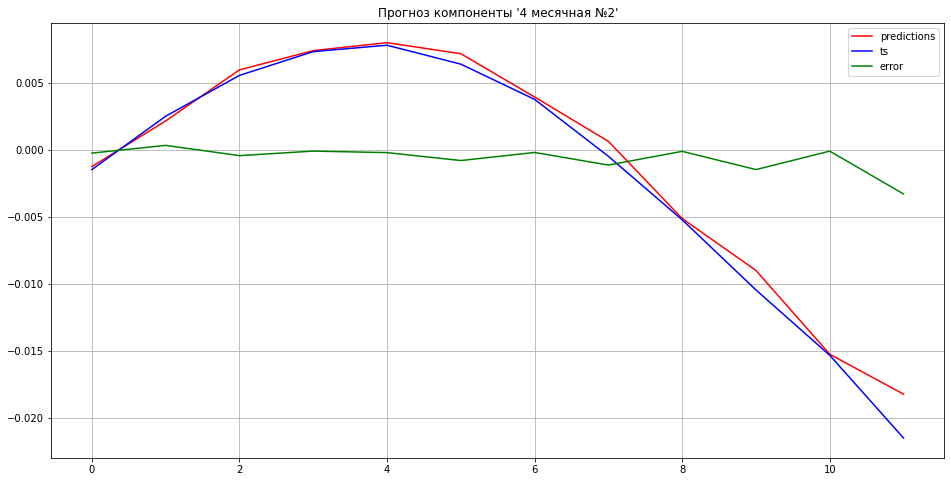

/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


R^2: 0.98
RMSE на норм.данных: 0.0011250109303864487


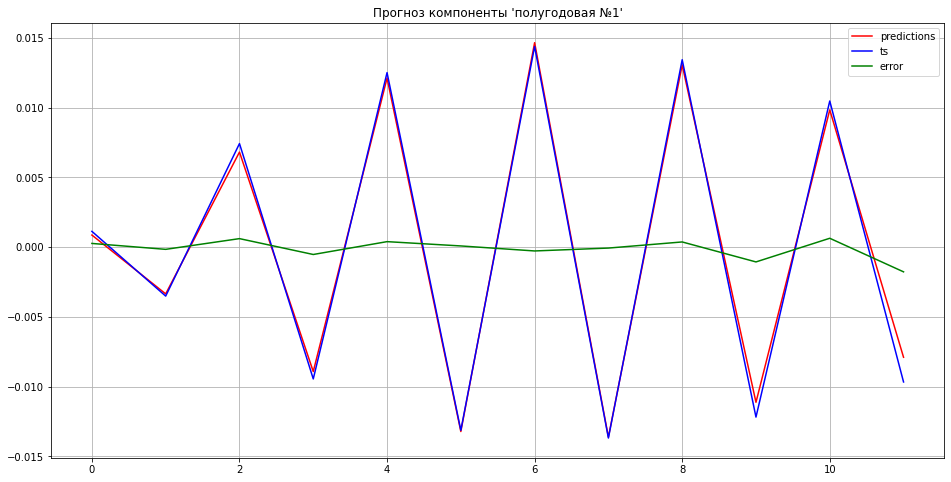

R^2: 1.00
RMSE на норм.данных: 0.0006949850736052457


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


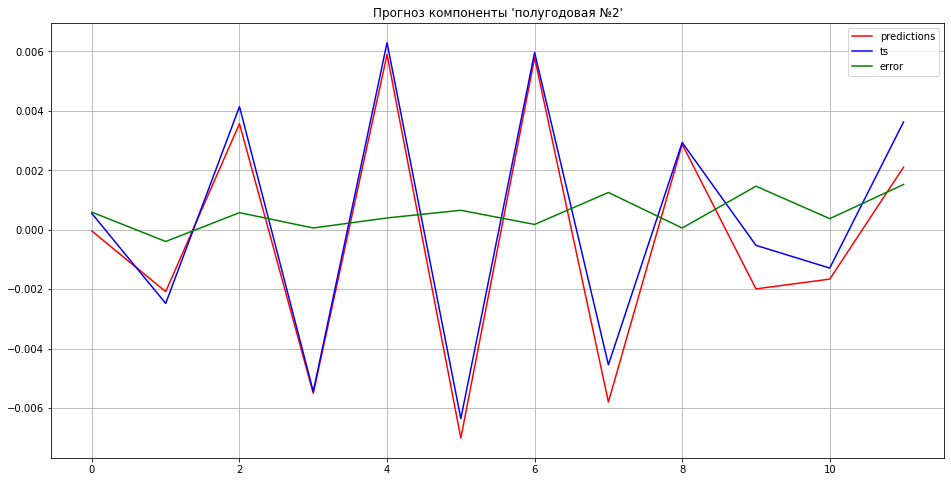

R^2: 0.96
RMSE на норм.данных: 0.0007974043027186378


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


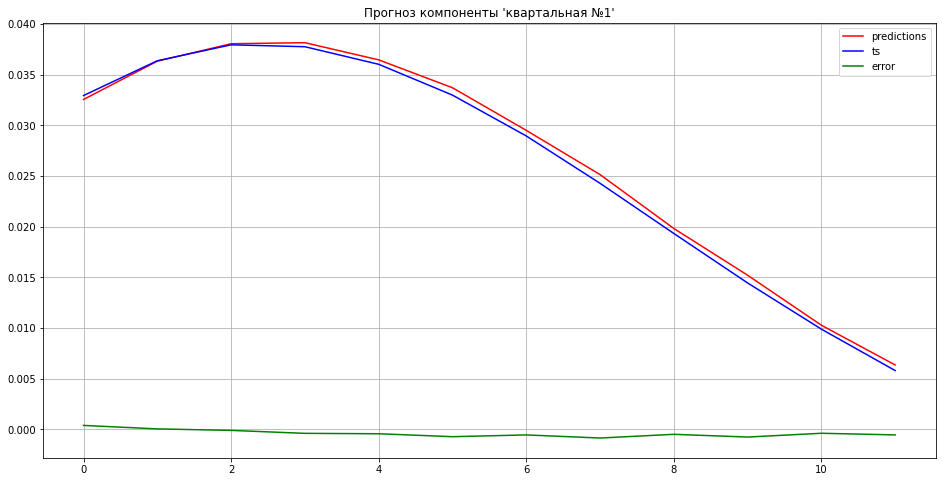

/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


R^2: 1.00
RMSE на норм.данных: 0.0005297607068557385


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


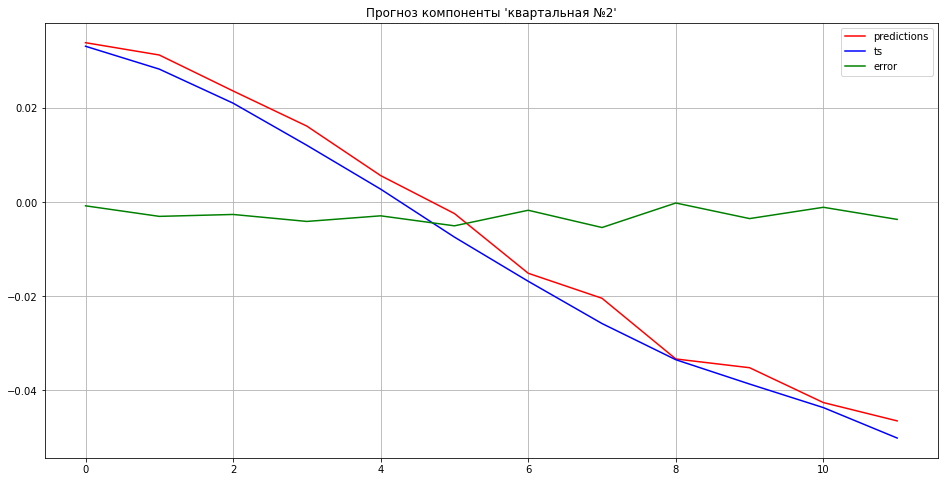

/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


R^2: 0.99
RMSE на норм.данных: 0.0032242599052624207


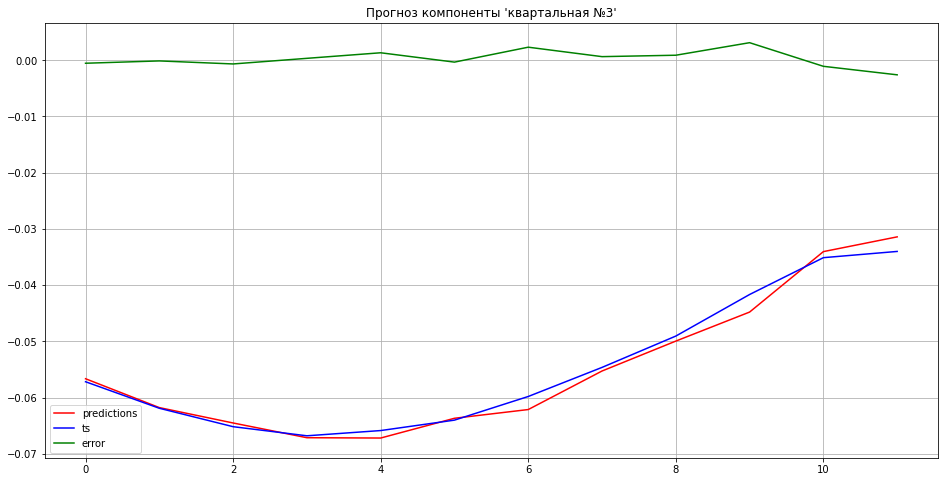

R^2: 0.98
RMSE на норм.данных: 0.0014991567011982134


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


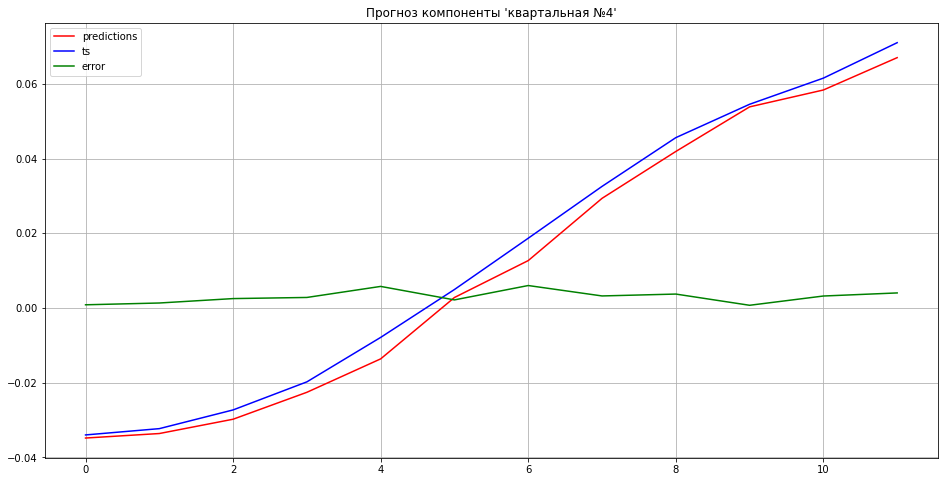

R^2: 0.99
RMSE на норм.данных: 0.0034220541427666443


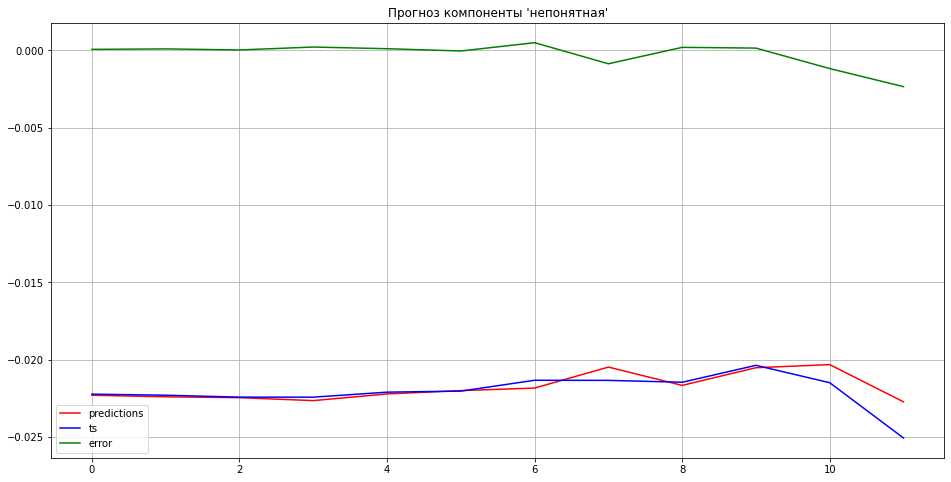

R^2: 0.43
RMSE на норм.данных: 0.000815664587873245


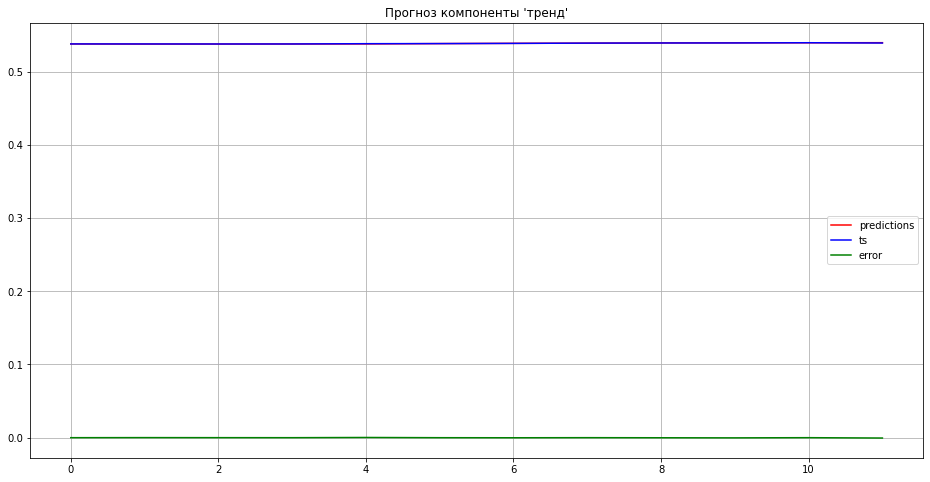

R^2: 0.91
RMSE на норм.данных: 0.00017898641359922083


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


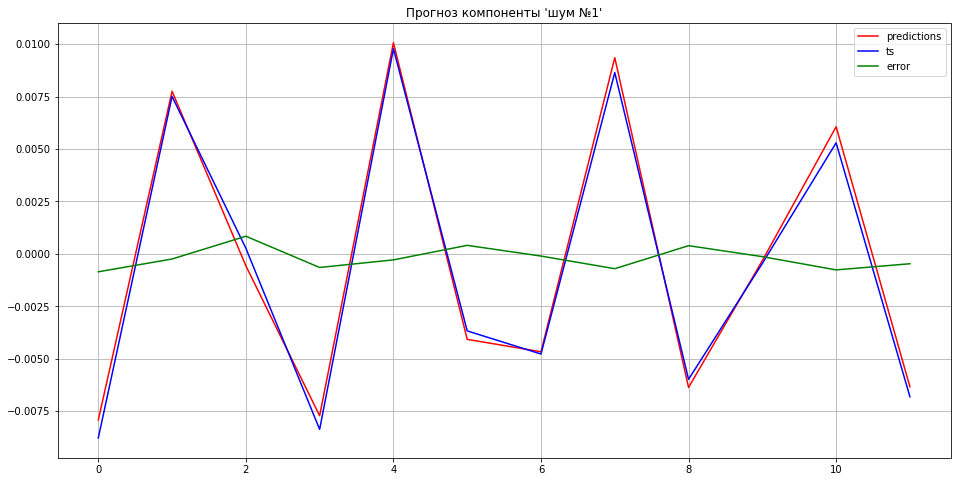

R^2: 0.99
RMSE на норм.данных: 0.0005530556890937154


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


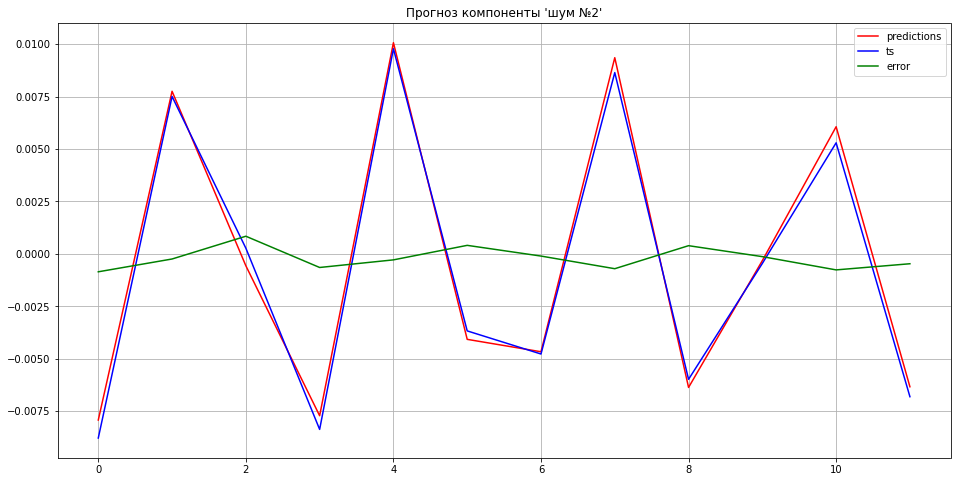

R^2: 0.99
RMSE на норм.данных: 0.0005530556890937154


/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rivalliteam/miniforge3/envs/tf_m1_3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


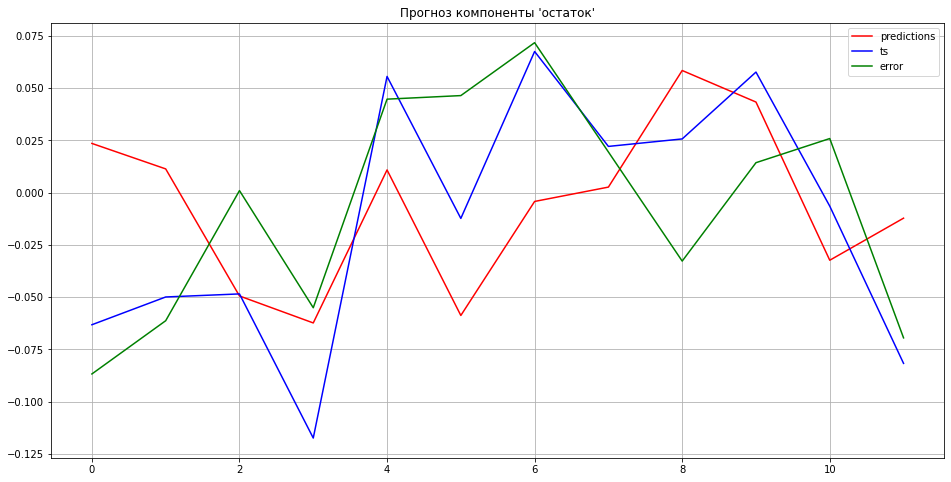

R^2: 0.23
RMSE на норм.данных: 0.05061202156197283
CPU times: user 26.7 s, sys: 16.4 s, total: 43.2 s
Wall time: 7.27 s


In [55]:
%%time

# выполню прогноз по каждой из составляющих ряда и по сумме составляющих
# тут сохраню сумму "n_predictions" предсказанных значений всех составляющих
summ_pred_ARIMA = np.zeros(n_predictions)

for key in ts_components.keys(): 
    # берем очередную сохраненную составляющую
    # обучаем модель
    ARIMA_result = ARIMA(ts_components[key]['X'], order = (p, d, q)).fit()
    # прогноз по составляющей ряда
    predictions = ARIMA_result.predict(len(ts_components[key]['X']) - n_predictions, \
                                       len(ts_components[key]['X']) - 1)
    # ошибка прогноза
    error = [ts_components[key]['X'][-n_predictions + i] - predictions[i] for i in range(n_predictions)]
    # суммирую прогнозы
    summ_pred_ARIMA = summ_pred_ARIMA + predictions
    # сохраняю прогноз и данные модели
    ts_components[key]['pred_ARIMA'] = predictions
    ts_components[key]['model_ARIMA'] = key + '_week_ARIMA.pkl'
    ARIMA_result.save(path_to_local_data + '/models/' + ts_components[key]['model_ARIMA'])
    # рисуем
    plt.figure(figsize = (16, 8))
    plt.plot(predictions, color = 'red', label = 'predictions')
    plt.plot(ts_components[key]['X'][-n_predictions:], color = 'blue', label = 'ts')
    plt.plot(error, color = 'green', label = 'error')
    plt.title(f"Прогноз компоненты '{key}'")
    plt.grid()
    plt.legend()
    plt.show()
    # печатаю метрики
    print('R^2: %1.2f' % r2_score(ts_components[key]['X'][-n_predictions:], predictions))
    print(f"RMSE на норм.данных: {np.sqrt(mean_squared_error(ts_components[key]['X'][-n_predictions:], predictions))}")

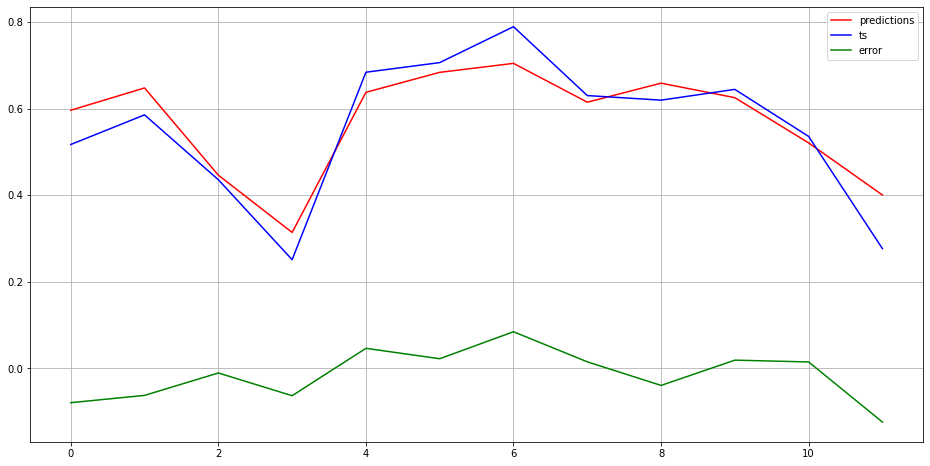

In [56]:
# рисуем прогноз и ошибку по сумме прогнозов компонент ряда
# ошибка по сумме прогнозов компонент
error = [ts[-n_predictions + i] - summ_pred_ARIMA[i] for i in range(n_predictions)]
# рисую
plt.figure(figsize = (16, 8))
plt.plot(summ_pred_ARIMA, color = 'red', label = 'predictions')
plt.plot(ts[-n_predictions:], color = 'blue', label = 'ts')
plt.plot(error, color = 'green', label = 'error')
plt.grid()
plt.legend()
plt.show()

In [57]:
# печатаю метрики модели и прогноза по сумме прогнозов компонент ряда
print('R^2: %1.2f' % r2_score(ts[-n_predictions:], summ_pred_ARIMA))
print(f'RMSE на норм. данных: {np.sqrt(mean_squared_error(ts[-n_predictions:], summ_pred_ARIMA))}')

R^2: 0.86
RMSE на норм. данных: 0.05895373653900548


    Предсказание ряда моделью ARIMA:
    - исходный ряд без разделения на компоненты - rmse 0.098, r^2 0.51
    - предсказание отдельно каждой из компонент, суммирование предсказаний - rmse 0.059, r^2 0.86
    - определяющий вклад в ошибку прогноза вносит компонента "остаток"
    - наблюдаем, что разбиение ряда на компоненты с последующим прогнозом как сумма прогнозов компонент дает лучший результат, и в смысле обощающей способности модели (r^2) и в смысле качества прогноза (rmse)

* [Содержание](#Table-Of-Contents)

<a id="NN"></a>
# 5.2 Применение искусственных нейронных сетей

In [58]:
# глубина прогноза
n_predictions = 12

2022-05-28 19:47:32.144636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-28 19:47:32.145482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Данные для обучения: фичи - (140, 104, 1), метки - (140,)
Metal device set to: Apple M1


2022-05-28 19:47:32.423204: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-28 19:47:32.751249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:32.853601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:33.016283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:33.563481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:33.606121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:47:43.706682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:43.740332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


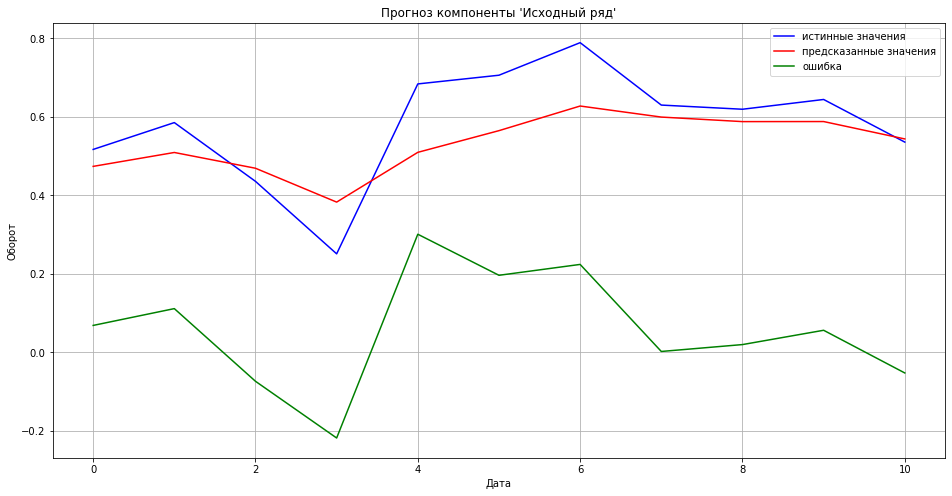

R^2: 0.50
RMSE на норм. данных: 0.09894444334134389
CPU times: user 11.2 s, sys: 2.37 s, total: 13.6 s
Wall time: 11.8 s


In [59]:
%%time

# используя искусственную нейронную сеть, предскажем значения по данным исходного временного ряда
L = 104

# формируем обучающий набор
features, labels = ts_feature_preparation(ts, window = L, n_predictions = n_predictions)
# обучение модели
model, _ = model_fit(lstm_model(L, (features.shape[1], 1), summary = False), \
                        features, labels, epochs = 50, batch_size = 16, validation_split = .2, verbose = 0)
# формируем тестовый набор - "n_predictions" последних значений ряда
test_features, test_labels = test_feature_preparation(ts, L, n_predictions)
# получаем предсказание
predictions = test_predict(model, test_features)
# ошибка прогноза
error = [ts[-n_predictions + i] - predictions[i] for i in range(n_predictions)]
# рисуем ошибку предсказания
pict_predict(predictions, test_labels, error, 1, 'Исходный ряд')

    Учитывая полученное значение коэффициента детерминации, можно сказать, что модель объясняет 60% дисперсии значений временного ряда.
    Ошибка на нормализованных данных временного ряда находится в пределах 9% (показатель RMSE = 0,088).

Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:47:44.348316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:44.465500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:44.546319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:45.054564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:45.096169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:47:54.587262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:54.622508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


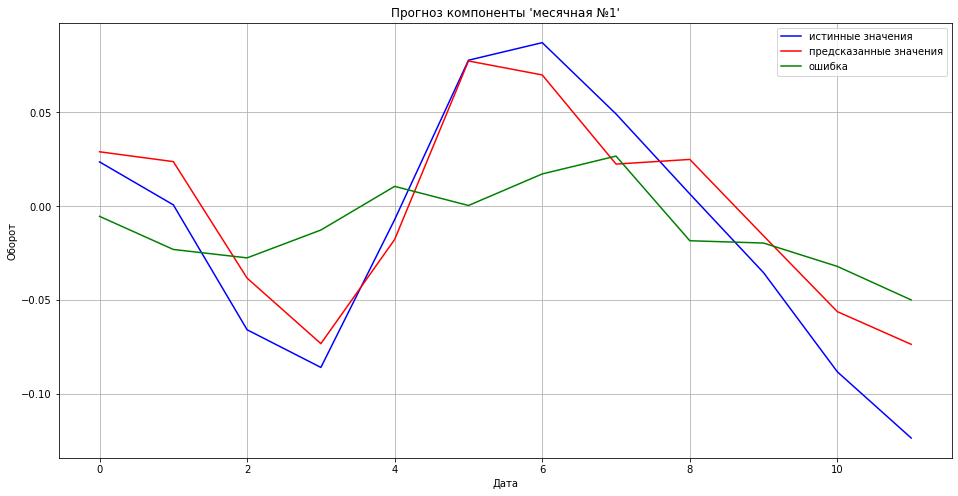

R^2: 0.86
RMSE на норм. данных: 0.023904300543589333
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:47:55.170800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:55.284347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:55.359393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:55.858710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:47:55.899706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:48:05.430090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:05.464970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


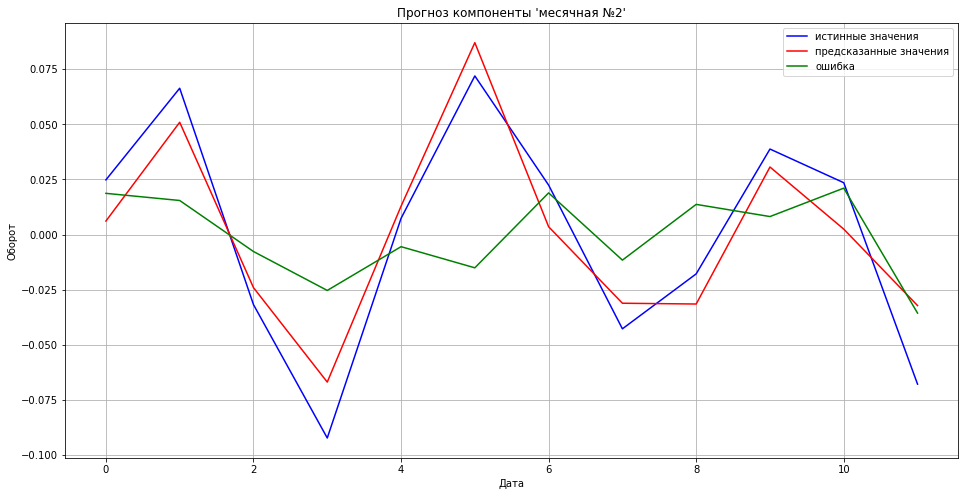

R^2: 0.86
RMSE на норм. данных: 0.018261911936946686
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:48:06.038921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:06.152829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:06.231610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:06.723068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:06.763567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:48:16.331441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:16.365729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


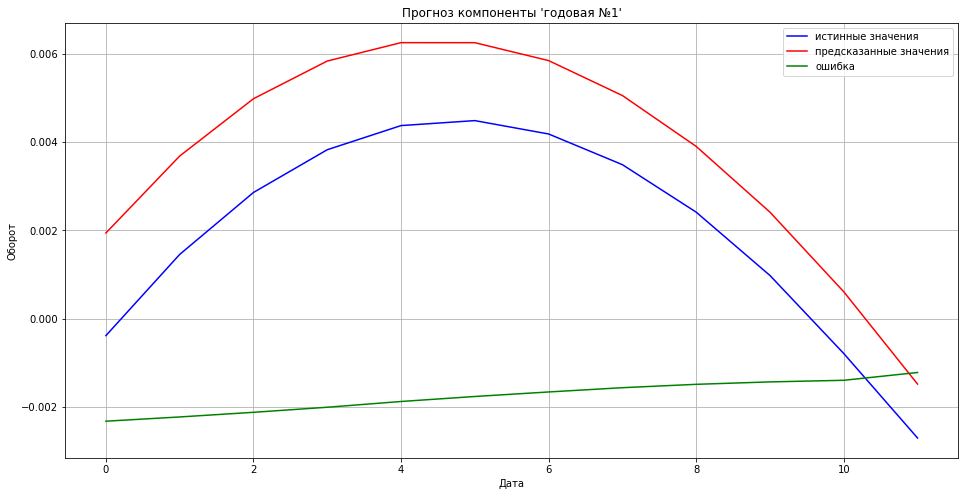

R^2: 0.36
RMSE на норм. данных: 0.0017912261988638795
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:48:17.108353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:17.219887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:17.295742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:17.767267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:17.807782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:48:27.390979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:27.427854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


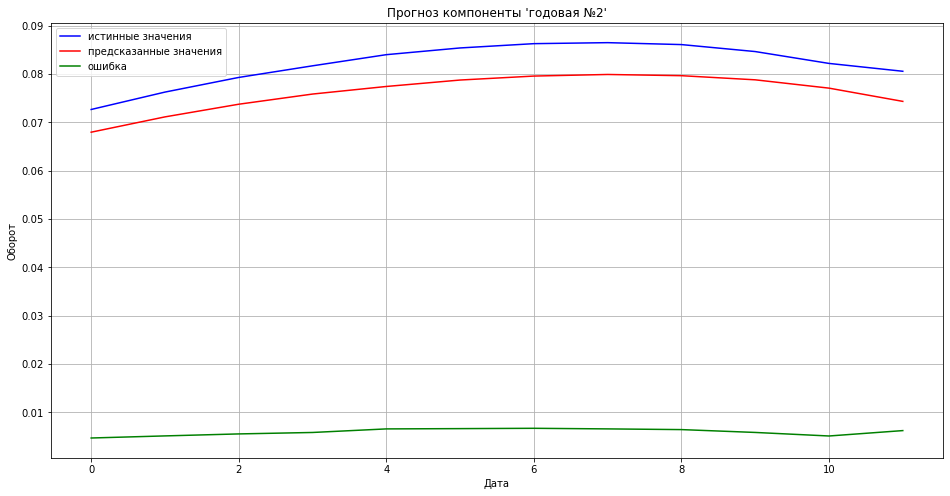

R^2: -1.07
RMSE на норм. данных: 0.005983852341795163
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:48:28.028861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:28.143364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:28.219353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:28.682617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:28.723344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:48:37.917279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:37.953479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


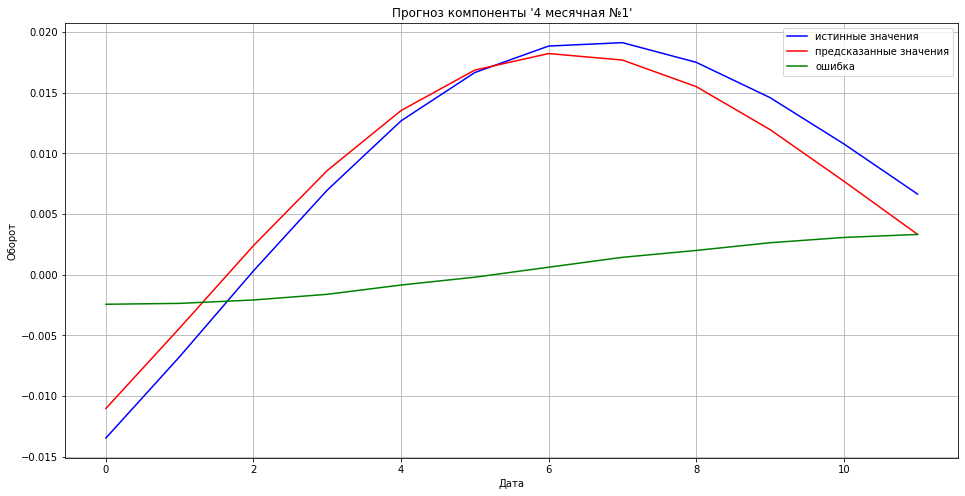

R^2: 0.96
RMSE на норм. данных: 0.0021005478542062274
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:48:38.543517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:38.658909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:38.735546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:39.230323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:39.275267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:48:48.606365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:48.642870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


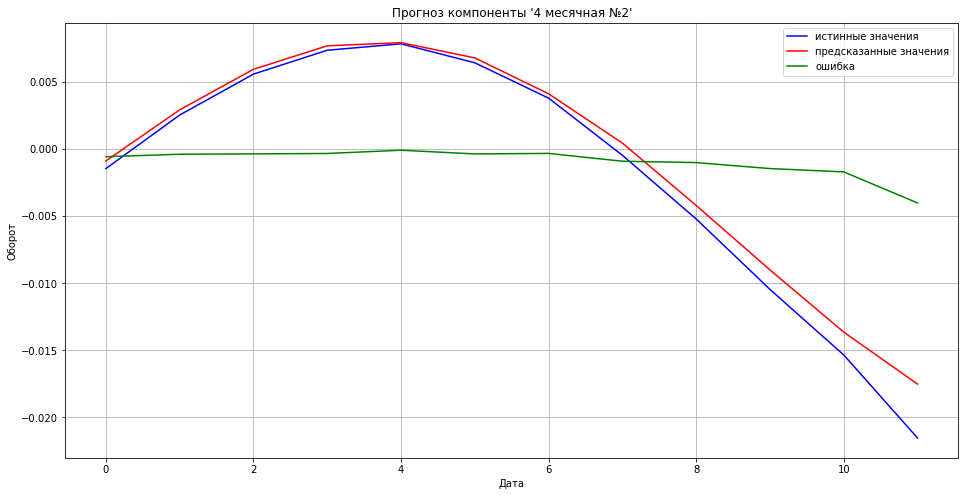

R^2: 0.98
RMSE на норм. данных: 0.0014126042054193795
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:48:49.138858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:49.231300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:49.357500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:49.822053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:49.862039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:48:59.947386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:48:59.984348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


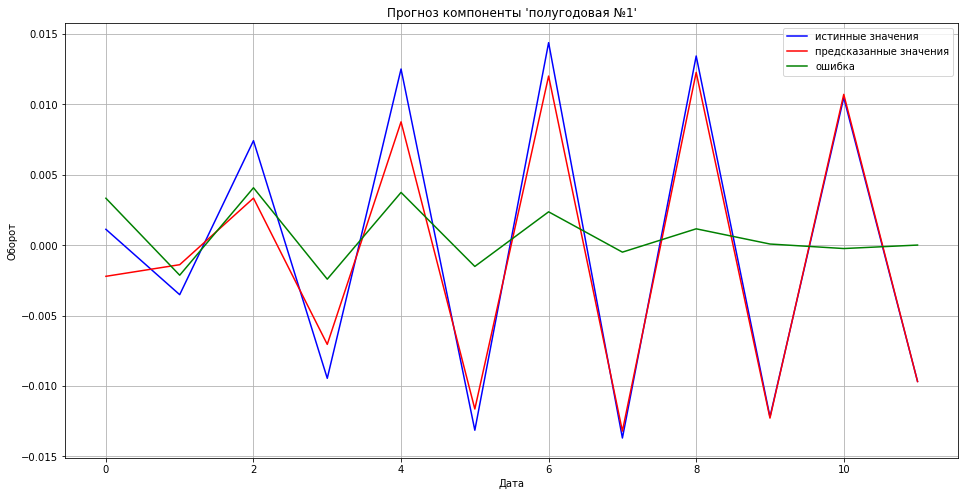

R^2: 0.96
RMSE на норм. данных: 0.0022690716172937535
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:49:00.561656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:00.666977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:00.819437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:01.414873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:01.458817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:49:11.991439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:12.026264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


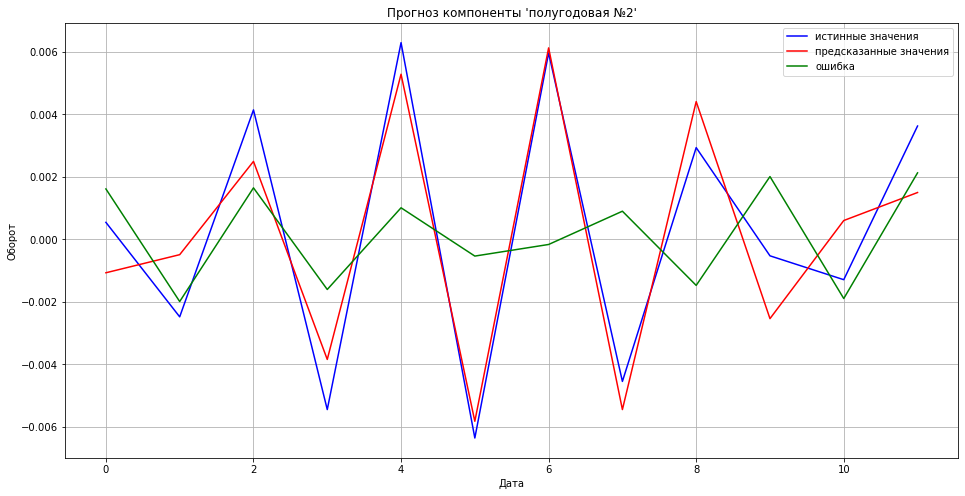

R^2: 0.87
RMSE на норм. данных: 0.0015363810235049149
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:49:12.775635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:12.887067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:12.975802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:13.481081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:13.521602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:49:23.086762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:23.122081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


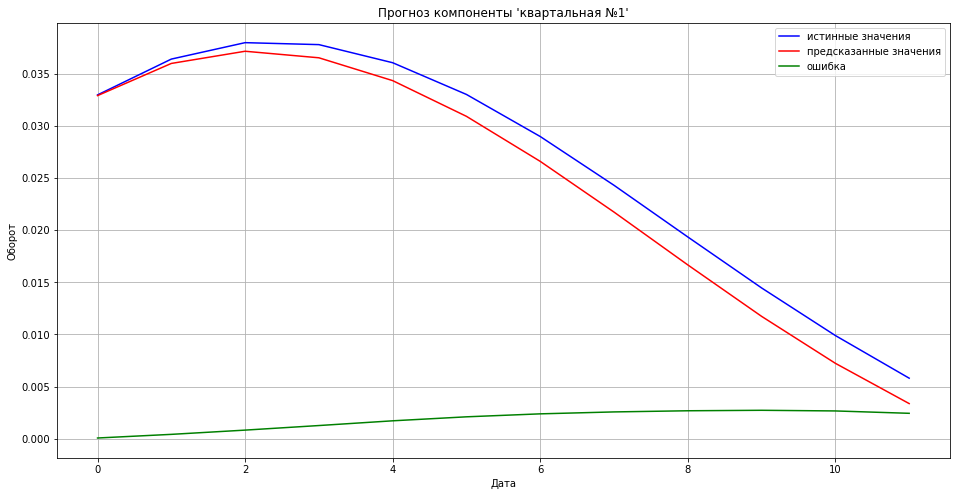

R^2: 0.97
RMSE на норм. данных: 0.002034711706931996
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:49:23.719068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:23.840091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:23.932390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:24.456743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:24.499420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:49:33.756681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:33.791670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


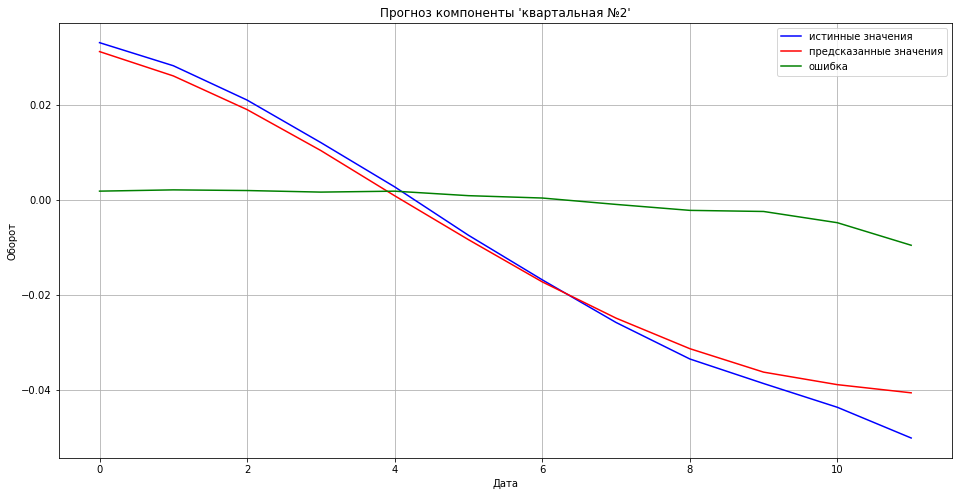

R^2: 0.98
RMSE на норм. данных: 0.0034680824471560595
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:49:34.335712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:34.447468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:34.527387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:35.014226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:35.055188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:49:44.034273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:44.069394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


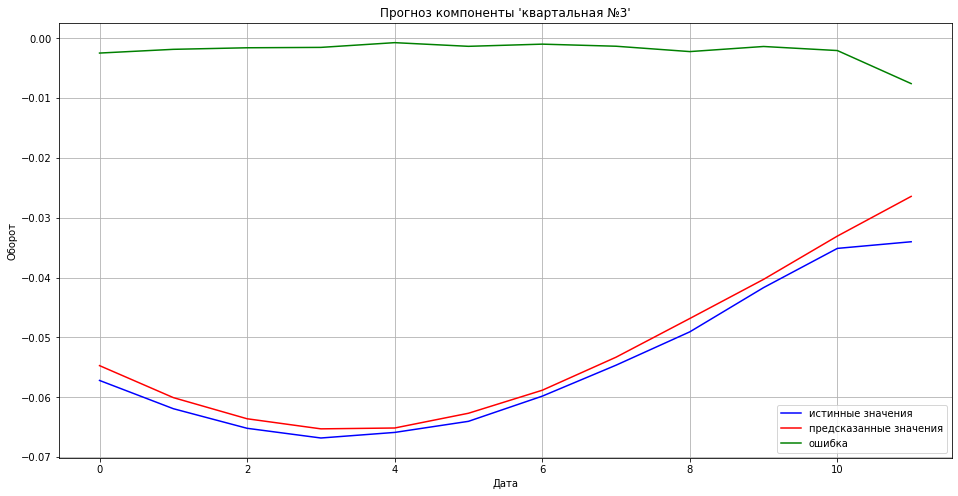

R^2: 0.94
RMSE на норм. данных: 0.0027097686793117744
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:49:44.772562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:44.883692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:44.966440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:45.451450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:45.492307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:49:55.140682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:55.178145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


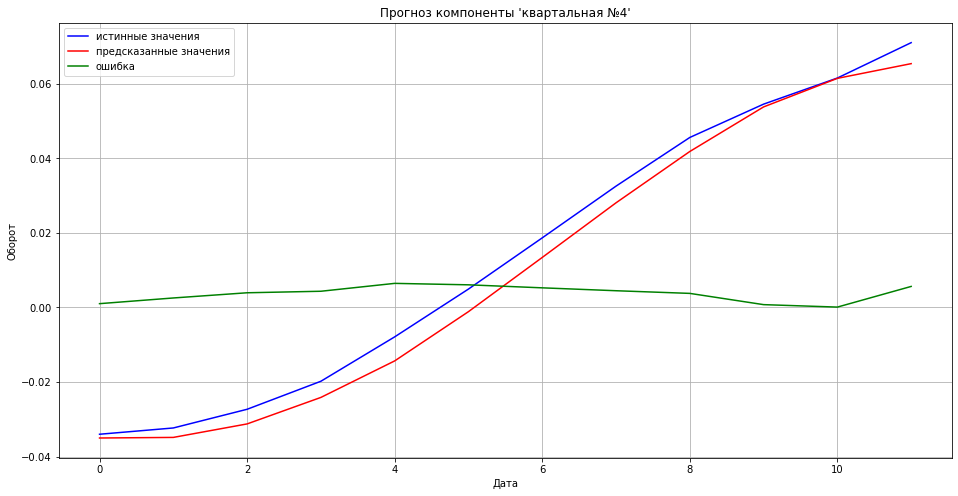

R^2: 0.99
RMSE на норм. данных: 0.004223150216628751
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:49:55.705654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:55.806749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:55.936335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:56.450641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:49:56.495114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:50:06.903871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:06.938614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


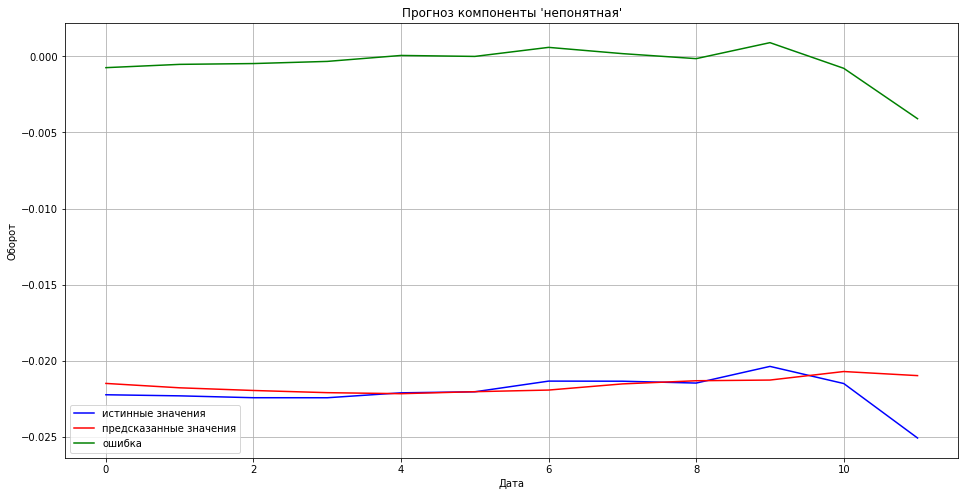

R^2: -0.41
RMSE на норм. данных: 0.0012840389331669308
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:50:07.488196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:07.585659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:07.717111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:08.361690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:08.403543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:50:18.582586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:18.617430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


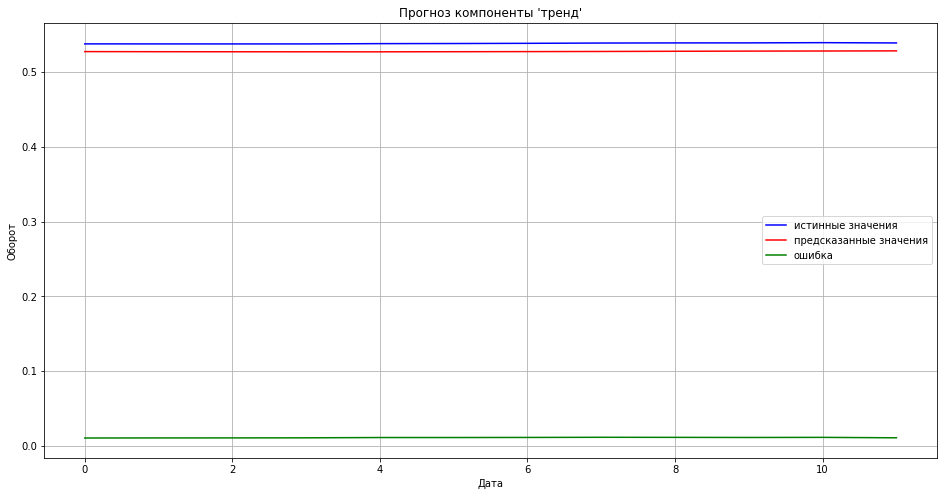

R^2: -311.40
RMSE на норм. данных: 0.010839537116713139
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:50:19.173614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:19.269657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:19.404994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:19.890334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:19.930884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:50:30.140820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:30.175575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


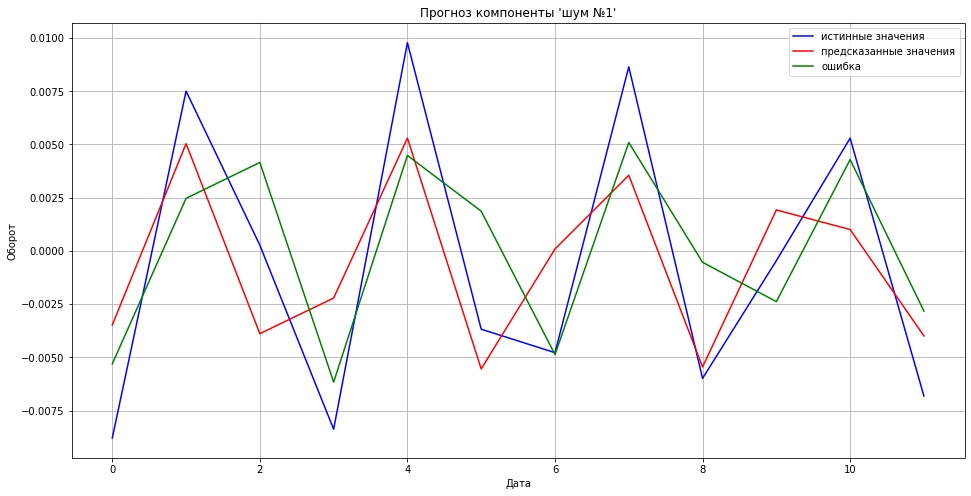

R^2: 0.62
RMSE на норм. данных: 0.004031152250129805
Данные для обучения: фичи - (140, 104, 1), метки - (140,)


2022-05-28 19:50:30.744786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:30.843695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:30.986178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:31.472773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:31.513982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 104, 1), метки - 12


2022-05-28 19:50:41.603741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:41.638090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


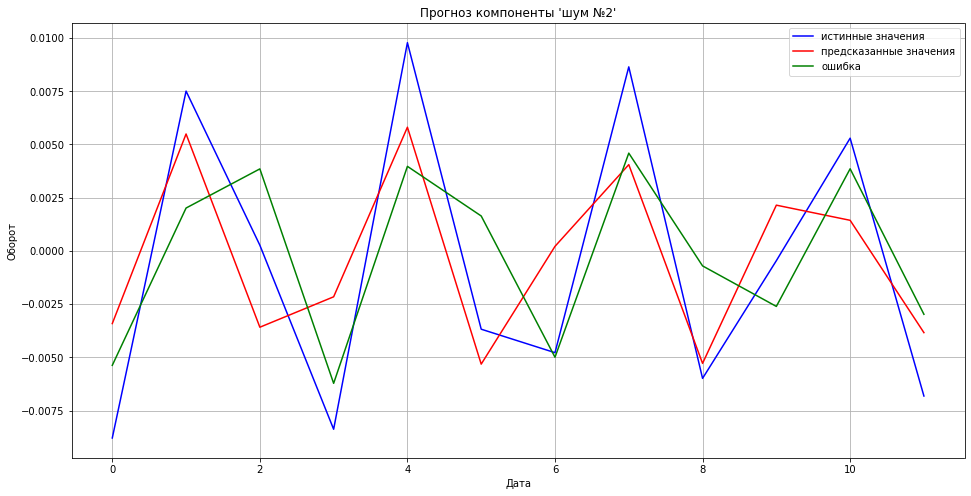

R^2: 0.65
RMSE на норм. данных: 0.0038937466140627026
Данные для обучения: фичи - (192, 52, 1), метки - (192,)


2022-05-28 19:50:42.407780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:42.518963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:42.600287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:43.102283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:43.143314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Данные для тестирования: фичи - (12, 52, 1), метки - 12


2022-05-28 19:50:52.421365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:52.456377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


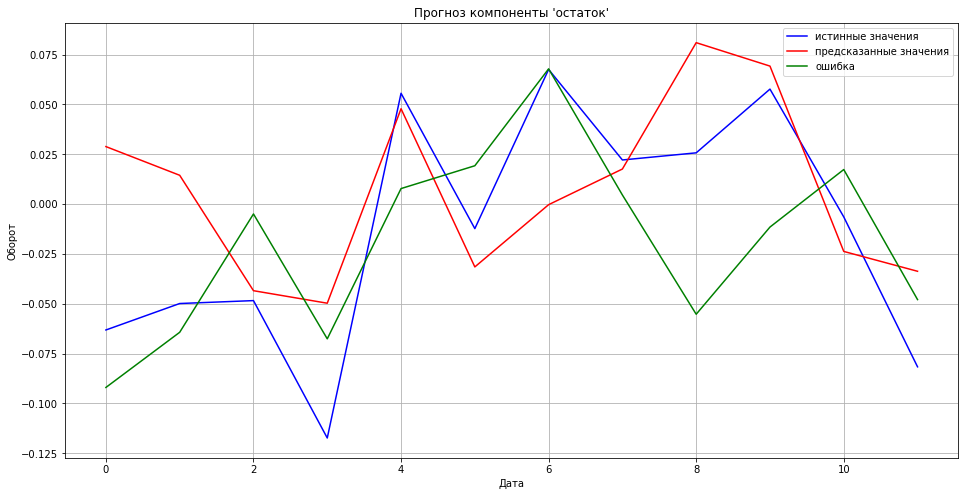

R^2: 0.29
RMSE на норм. данных: 0.048327513892529955
CPU times: user 3min 3s, sys: 43.8 s, total: 3min 47s
Wall time: 3min 8s


In [60]:
%%time

# используя искусственную нейронную сеть, предскажем значения по каждой из найденных составляющих исходного 
# временного ряда, далее, просуммируем предсказания всех моделей и сравним со значениями исходного временного ряда

n_predictions = 12 # делаем "n_predictions" предсказаний
summ_pred = np.zeros(n_predictions) # тут сохраним сумму "n_predictions" предсказанных значений всех составляющих

for key in ts_components.keys(): 
    # берем очередную сохраненную составляющую
    if key in ['тренд', 'полугодовая №1', 'полугодовая №2', 'шум №1', 'шум №2', 'непонятная']:
        L = 104 # окно анализа
    elif key in ['квартальная №1', 'квартальная №2', '4 месячная №1', '4 месячная №2']:
        L = 52
    elif key in ['квартальная №3', 'квартальная №4', 'годовая №1', 'годовая №2']:
        L = 52
    elif key in ['остаток']:
        L = 52
    else:
        L = 52 # окно анализа для составляющих малой периодичности
    # формируем обучающий набор
    features, labels = \
                ts_feature_preparation(ts_components[key]['X'], window = L, n_predictions = n_predictions)
    # обучение модели
    model, _ = model_fit(lstm_model(L, (features.shape[1], 1), summary = False), \
                            features, labels, epochs = 50, batch_size = 16, validation_split = .2, verbose = 0)
    # формируем тестовый набор - "n_predictions" последних значений ряда
    test_features, test_labels = test_feature_preparation(ts_components[key]['X'], L, n_predictions)
    # получаем предсказание
    predictions = test_predict(model, test_features)
    # ошибка прогноза
    error = [ts_components[key]['X'][-n_predictions + i] - predictions[i] for i in range(n_predictions)]
    # фиксируем предсказание по составляющей
    ts_components[key]['pred_NN'] = predictions.reshape(summ_pred.shape)
    ts_components[key]['model_NN'] = key + '_week_NN.h5'
    ts_components[key]['L_model_NN'] = L
    model.save(path_to_local_data + '/models/' + ts_components[key]['model_NN'])
    # суммируем предсказания по составляющим временного ряда
    summ_pred = summ_pred + predictions.reshape(summ_pred.shape)
    # рисуем ошибку предсказания
    pict_predict(predictions, test_labels, error, 0, key)

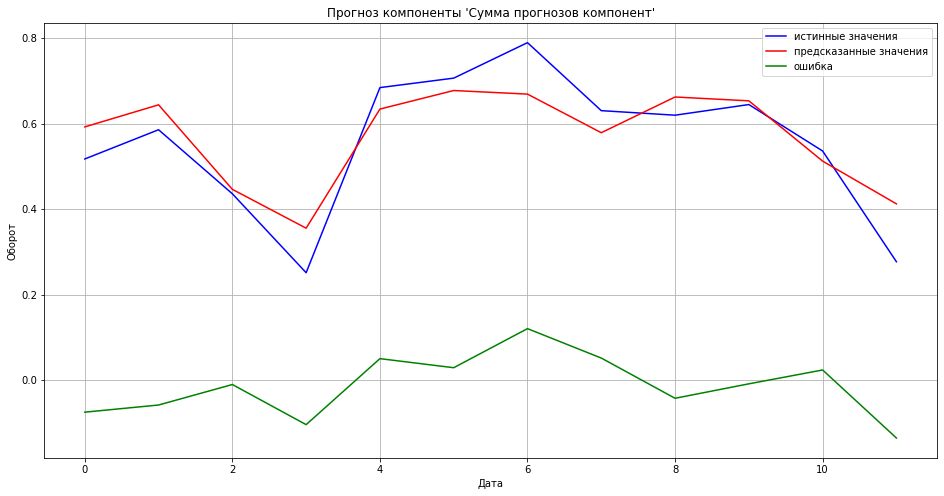

R^2: 0.79
RMSE на норм. данных: 0.07144644230326673


In [61]:
# рисуем прогноз и ошибку по сумме прогнозов компонент ряда
# ошибка по сумме прогнозов компонент
error = [ts[-n_predictions + i] - summ_pred[i] for i in range(n_predictions)]
# рисую
pict_predict(summ_pred, ts[-n_predictions:], error, 0, 'Сумма прогнозов компонент')

In [62]:
# сохраню результаты на всякий случай
# данные и предсказания составляющих временного ряда
with open('../results/ts_components_weeks.pkl',"wb") as file:
    pickle.dump(ts_components, file)

    Предсказание ряда LSTM-сетью:
    - исходный ряд без разделения на компоненты - rmse 0.098, r^2 0.5
    - предсказание отдельно каждой из компонент, суммирование предсказаний - rmse 0.07, r^2 0.79
    - определяющий вклад в ошибку прогноза вносит компонента "остаток"
    - наблюдаю, что разбиение ряда на компоненты с последующим прогнозом как сумма прогнозов компонент дает лучший результат, и в смысле обобщающей способности модели (r^2) и в смысле качества прогноза (rmse)

* [Содержание](#Table-Of-Contents)

<a id="TS-Modeling-Forecasting-Conclusion"></a>
# 6. Выводы по результатам вариантов решения задачи и выбор оптимального варианта

    Таким образом, имеем 4 варианта решения задачи прогнозирования продаж методом анализа истории продаж за период (временной ряд объемов продаж):
    - метод ARIMA - без разложения временного ряда на составляющие/ с разложением (SSA)
    - с применением искусственных нейронных сетей - без разложения временного ряда на составляющие/ с разложением (SSA)
    Для анализа и сравнения качества моделей использовались метрики:
    - r^2 (коэффициент детерминации) - как показатель обобщающей способности модели
    - rmse (среднеквадратическая ошибка) - как показатель точности прогноза (сравнение с имеющимися истинными данными)
    В результате проведенного эксперимента получены следующие результаты:
    - в1 (ARIMA, ряд целиком): rmse 0.098, r^2 0.51
    - в2 (ARIMA, по компонентам): rmse 0.059, r^2 0.86
    - в3 (LSTM, ряд целиком): rmse 0.098, r^2 0.5
    - в4 (LSTM, по компонентам): rmse 0.07, r^2 0.79
    Наблюдаю, что лучшие показатели метрик достигнуты в случае применения алгоритма ARIMA с предварительным разложением исходного временного ряда на компоненты.

    Проведу проверку качества прогнозирования на накопленных за последнее время данных, т.е. возьму модели, обученные на данных за период до 1/01/2022, и построю с их помощью прогноз на период с 1/01/2022 по 23/02/2022. Далее, посчитаю метрики по истинным данным, имеющимся за прогнозируемый период.
    При этом, методики ARIMA и LSTM буду применять к временному ряду, разложенному на компоненты.

In [63]:
# загружаю результаты обработки временного ряда - понадобятся для подготовки прогноза
with open('../results/ts_components_weeks.pkl',"rb") as file:
    ts_components = pickle.load(file)

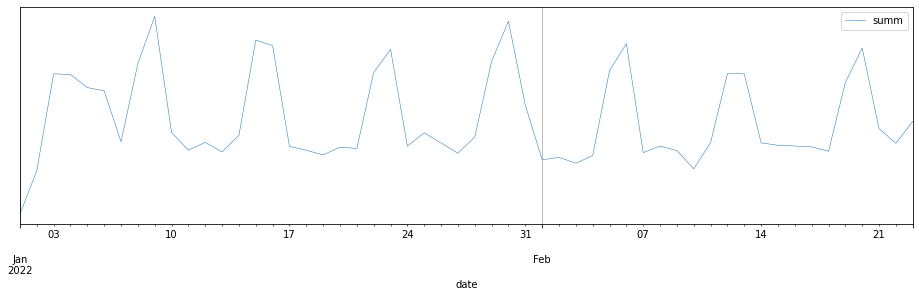

In [64]:
# загружаю данные по продажам за прогнозируемый период (для проверки)
df_CD_prov = pd.read_csv(path_to_local_data + '/data/ts_days_prov.csv', header = None, sep = ';', \
                         names = ['date', 'summ'])
# привожу данные к нужным типам
df_CD_prov['date'] = pd.to_datetime(df_CD_prov['date'], format = "%d.%m.%Y")
df_CD_prov['summ'] = df_CD_prov['summ'].astype('float64')
# установливаю дату в качестве индекса
df_CD_prov = df_CD_prov.set_index('date')
# рисую
df_CD_prov.plot(figsize = (16, 4), yticks = [], lw = .5)
plt.grid()
plt.show()

In [65]:
# проверочный временной ряд с группировкой по неделям
ts_prov = df_CD_prov['summ'].resample('W').sum().values

In [66]:
# нормализуем проверочный ряд
ts_prov = scaler.transform(ts_prov.reshape(-1, 1)).reshape(1,-1)[0]
ts_prov.shape

(9,)

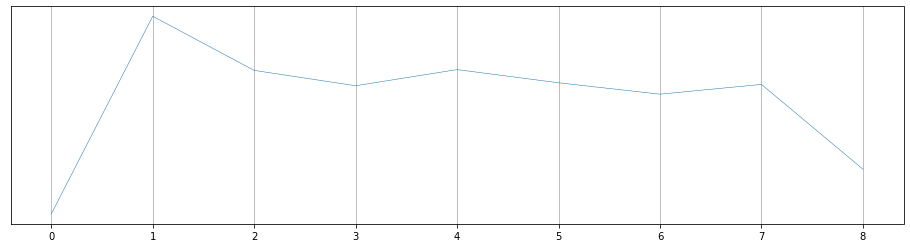

In [67]:
plt.figure(figsize = (16, 4))
plt.plot(ts_prov, lw = .5)
plt.yticks([])
plt.grid()
plt.show()

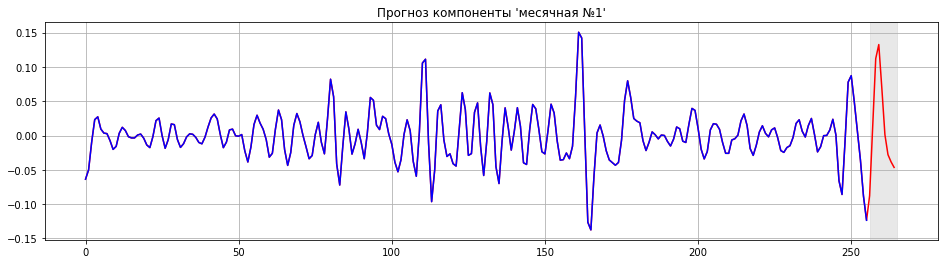

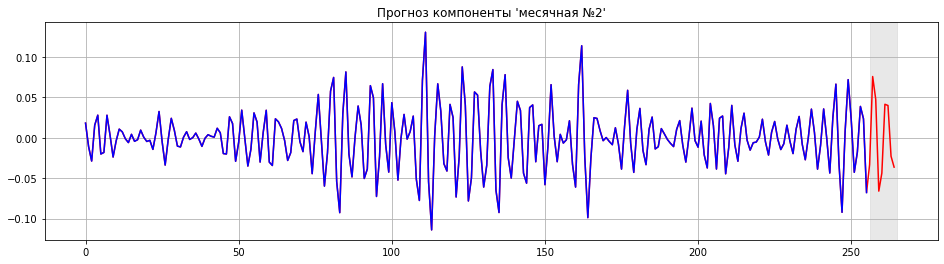

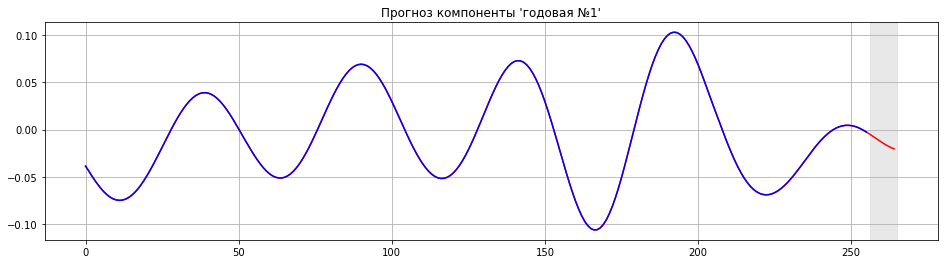

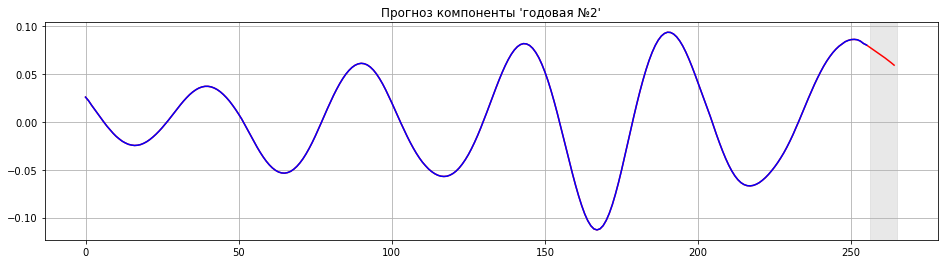

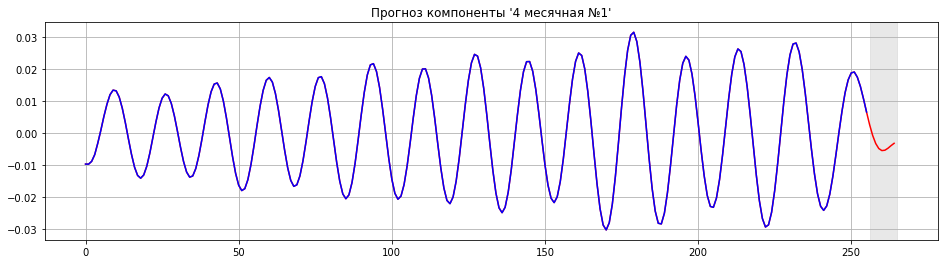

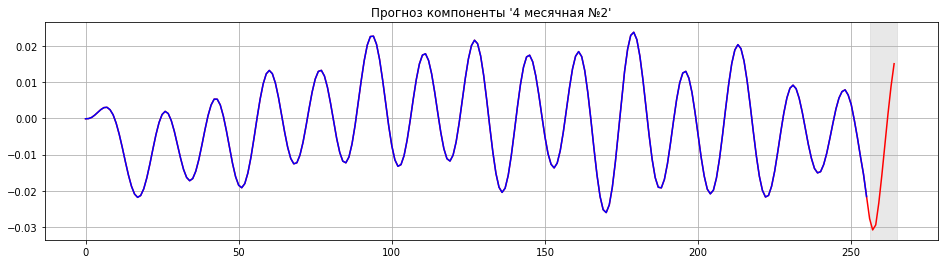

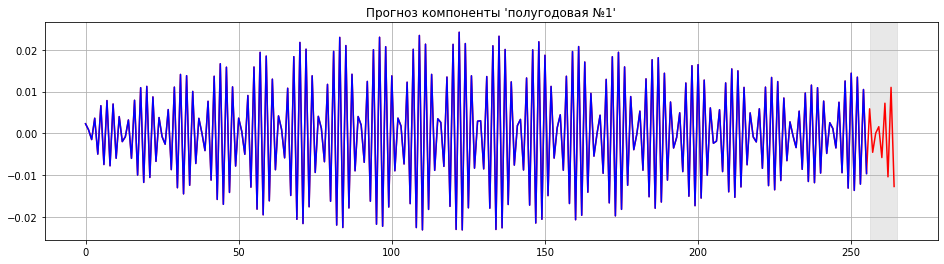

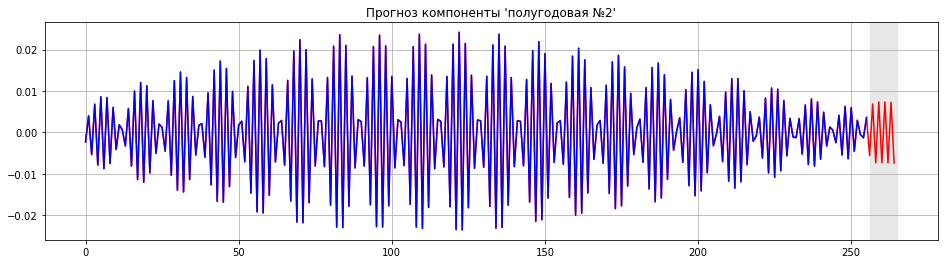

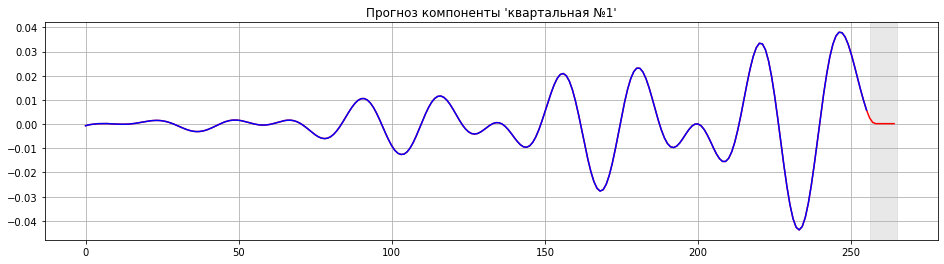

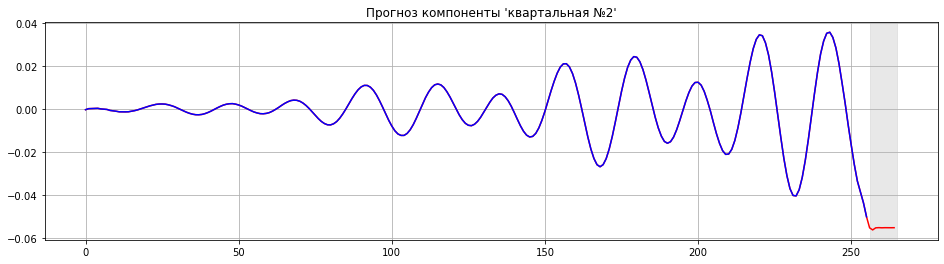

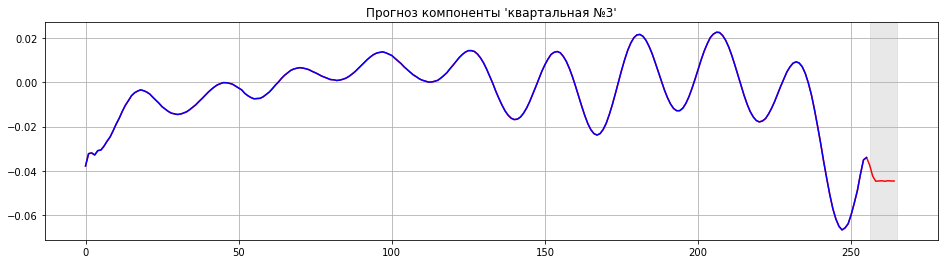

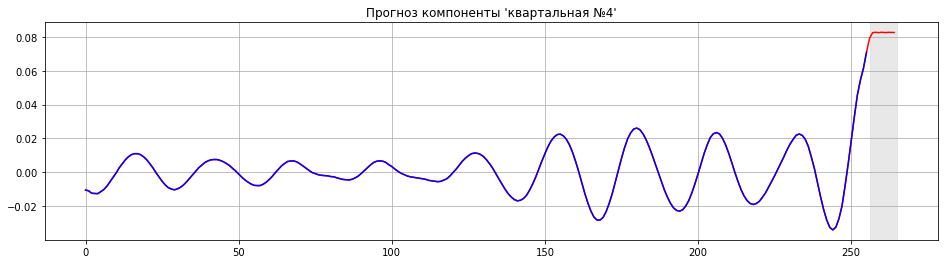

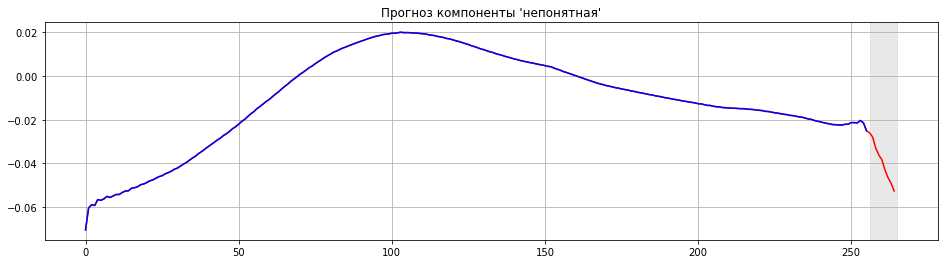

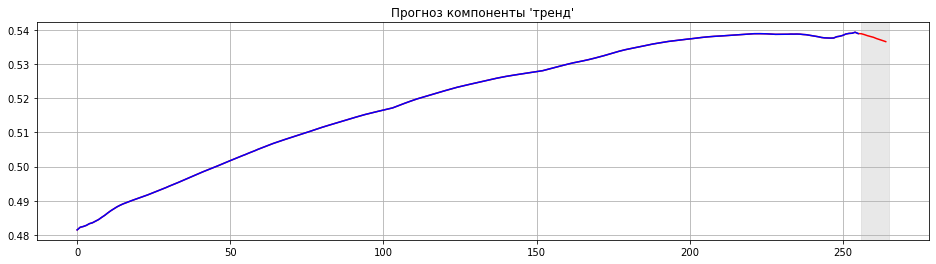

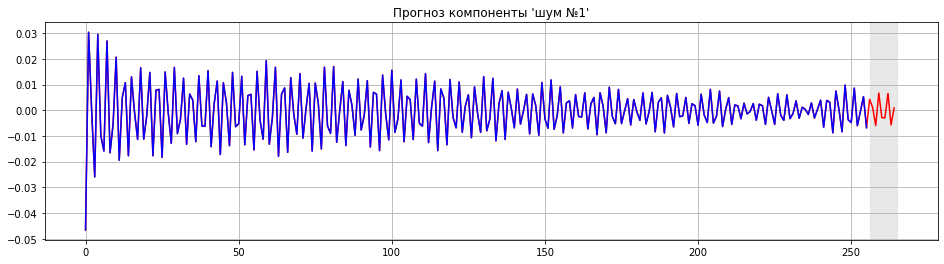

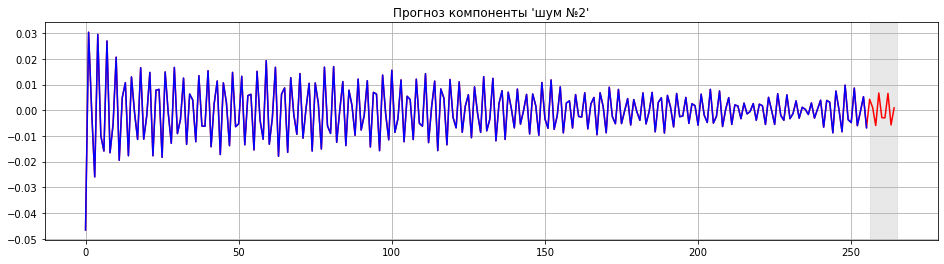

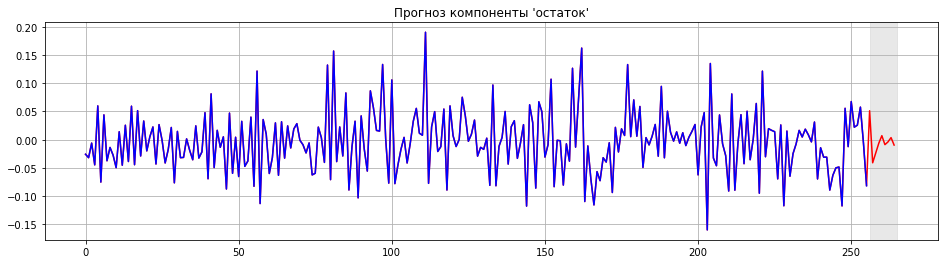

In [68]:
# прогноз ARIMA

n_predictions = ts_prov.shape[0]
summ_pred_ARIMA = np.zeros(n_predictions)

for key in ts_components.keys(): 
    # загружаю модель
    ARIMA_result = ARIMAResults.load(path_to_local_data + '/models/' + ts_components[key]['model_ARIMA'])
    # делаю прогноз
    predictions = ARIMA_result.predict(len(ts), len(ts) + n_predictions - 1)
    # суммирую прогнозы
    summ_pred_ARIMA = summ_pred_ARIMA + predictions
    # рисуем
    plt.figure(figsize = (16, 4))
    plt.plot(np.hstack([ts_components[key]['X'], predictions]), color = 'red')
    plt.plot(ts_components[key]['X'], color = 'blue')
    plt.title(f"Прогноз компоненты '{key}'")
    plt.axvspan(len(ts), len(np.hstack([ts_components[key]['X'], predictions])), alpha=0.5, color='lightgrey')
    plt.grid()
    plt.show()

2022-05-28 19:50:54.173105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:54.210068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


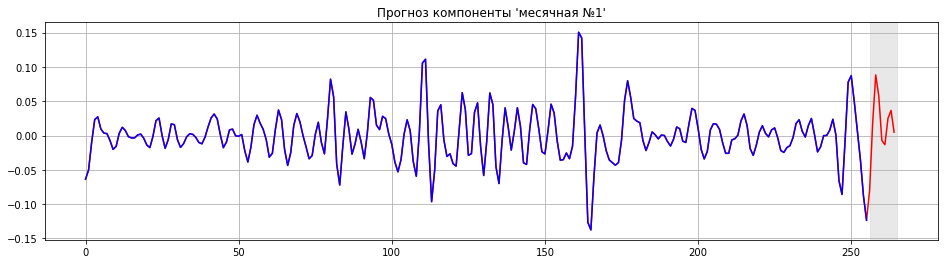

2022-05-28 19:50:54.709178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:54.745784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


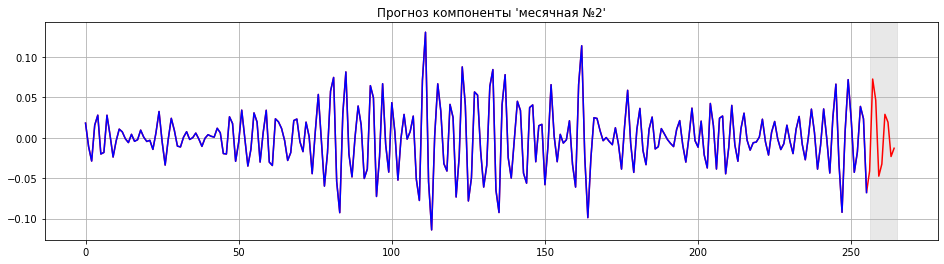

2022-05-28 19:50:55.239892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:55.276636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


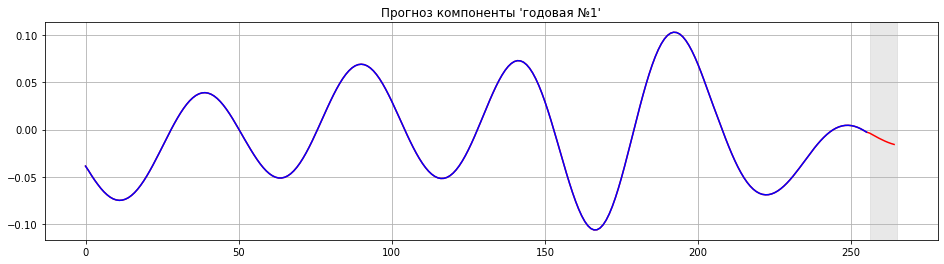

2022-05-28 19:50:55.754118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:55.789020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


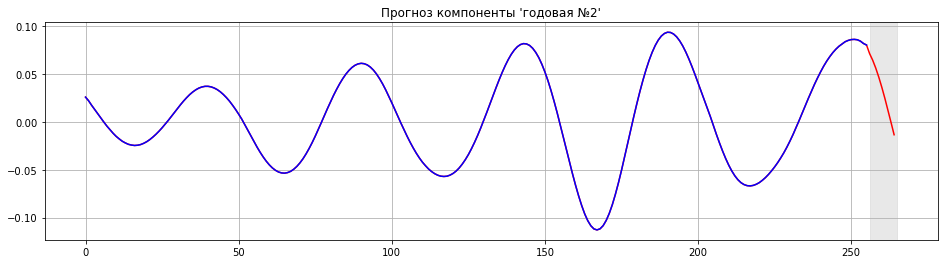

2022-05-28 19:50:56.252856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:56.288494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


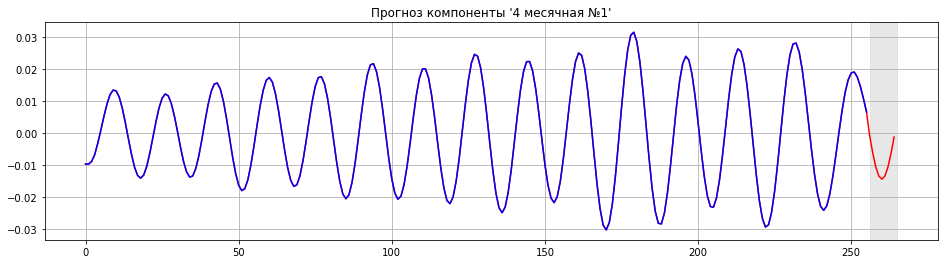

2022-05-28 19:50:56.777743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:56.816674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


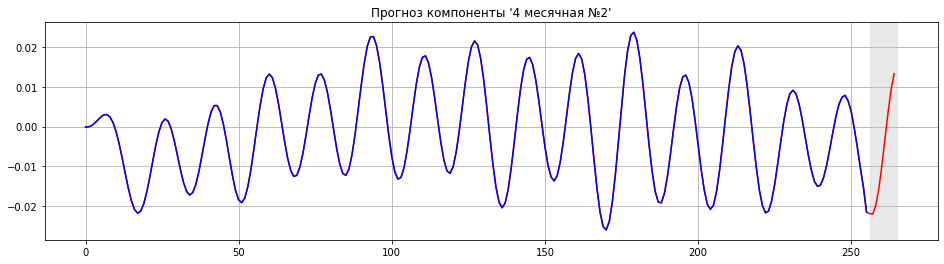

2022-05-28 19:50:57.318751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:57.356728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


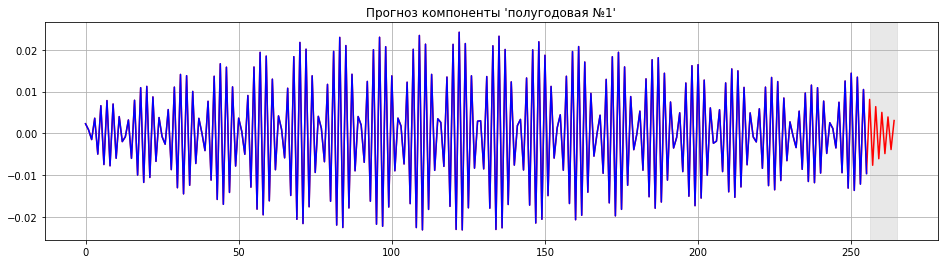

2022-05-28 19:50:57.959744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:57.996626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


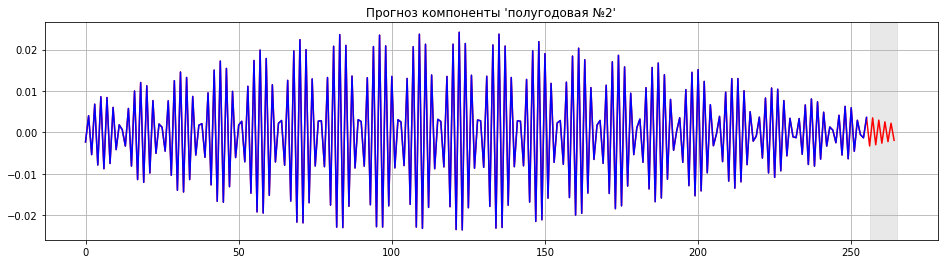

2022-05-28 19:50:58.572991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:58.609544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


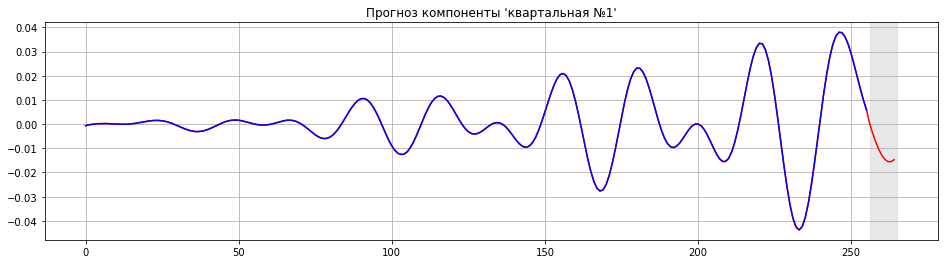

2022-05-28 19:50:59.198807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:59.234495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


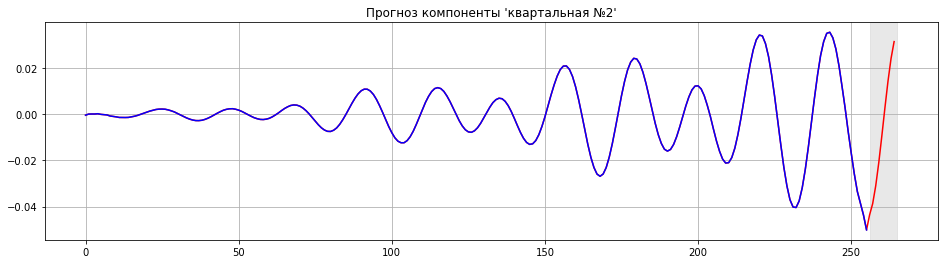

2022-05-28 19:50:59.697640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:50:59.734817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


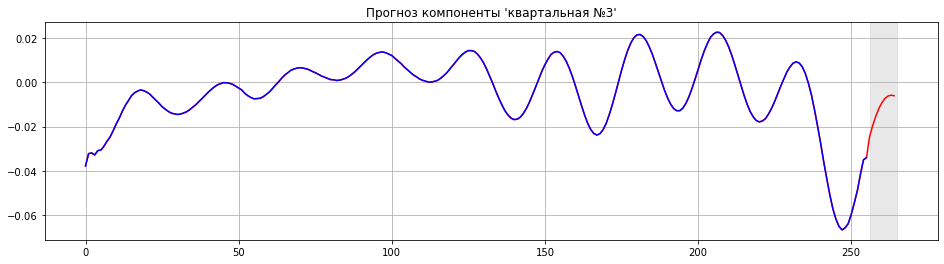

2022-05-28 19:51:00.239189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:00.275816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


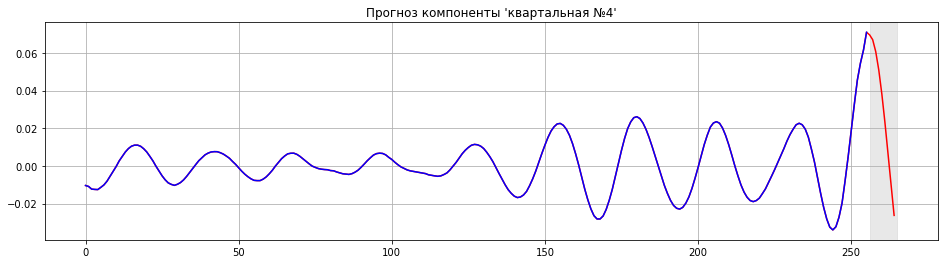

2022-05-28 19:51:00.756976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:00.793505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


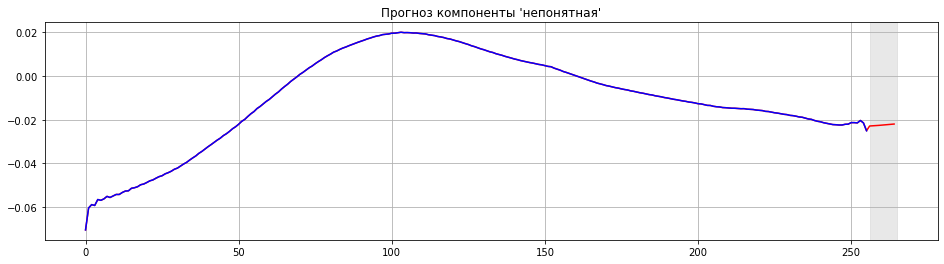

2022-05-28 19:51:01.363059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:01.398139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


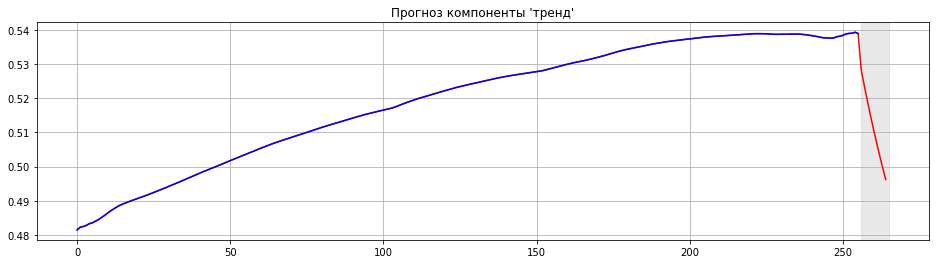

2022-05-28 19:51:02.035265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:02.070780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


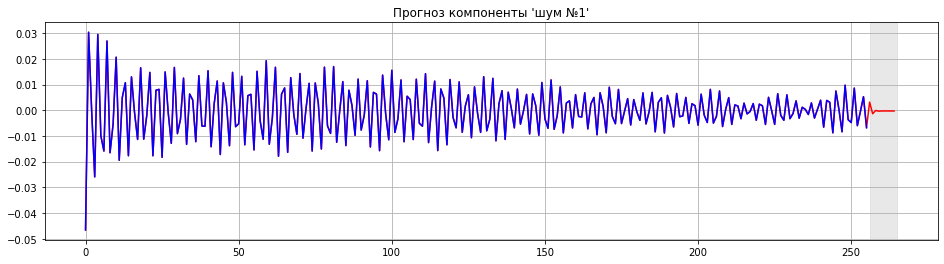

2022-05-28 19:51:02.634321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:02.670082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


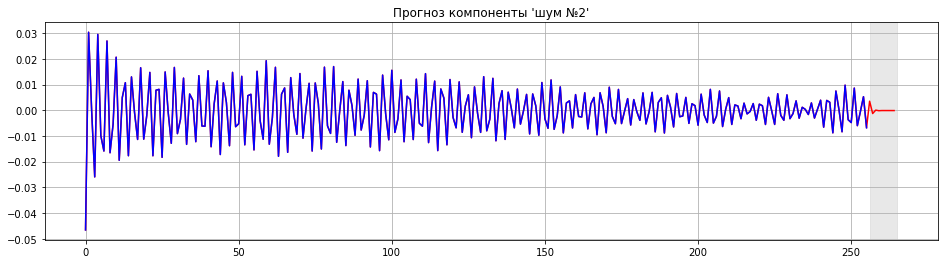

2022-05-28 19:51:03.237949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-28 19:51:03.274404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


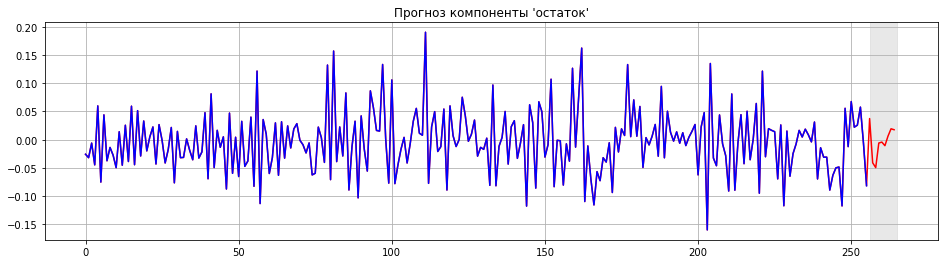

In [69]:
# прогноз LSTM

n_predictions = ts_prov.shape[0]
summ_pred_NN = np.zeros(n_predictions)

for key in ts_components.keys():
    # загружаю модель
    model = load_model(path_to_local_data + '/models/' + ts_components[key]['model_NN'])
    # получаем предсказание
    features = ts_components[key]['X']
    for i in range(n_predictions):
        test_features = []
        test_features.append(np.array(features[-ts_components[key]['L_model_NN']:]))
        test_features = np.array(test_features)
        test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))   
        pred = test_predict(model, test_features)
        features = np.append(features, pred)
    # суммируем предсказания по составляющим временного ряда
    summ_pred_NN = summ_pred_NN + features[-n_predictions:]
    # рисуем
    plt.figure(figsize = (16, 4))
    plt.plot(features, color = 'red')
    plt.plot(features[:-n_predictions], color = 'blue')
    plt.title(f"Прогноз компоненты '{key}'")
    plt.axvspan(len(ts), len(features), alpha = 0.5, color = 'lightgrey')
    plt.grid()
    plt.show()

In [70]:
summ = [summ_pred_ARIMA, summ_pred_NN]
titles = ['Сумма прогнозов компонент ARIMA', 'Сумма прогнозов компонент LSTM']

n_rows = 2

def pict_prov(shift = 0):
    fig = plt.figure(figsize=(16,6))
    axes = fig.subplots(n_rows, 1)
    for row_num in range(n_rows):
        # ошибки
        error = [ts_prov[-ts_prov.shape[0]:-1][i] - summ[row_num][-ts_prov.shape[0]+1:][i] \
                 for i in range(ts_prov.shape[0]-1)]
        # рисуем
        ax = axes[row_num]
        ax.plot(summ[row_num][-ts_prov.shape[0]+1 + shift:], color = 'red', label = 'прогноз')
        ax.plot(ts_prov[-ts_prov.shape[0] + shift:-1], color = 'blue', label = 'истинные значения')
        ax.plot(error[shift:], color = 'green', label = 'ошибка')
        ax.set_title(titles[row_num])
        ax.legend()
        ax.grid()
    fig.tight_layout()
    plt.show()
    # печатаю метрики прогноза по сумме прогнозов компонент ряда
    print(f'RMSE на норм. данных (ARIMA): ' \
          f'{np.sqrt(mean_squared_error(ts_prov[shift:-1], summ[0][-ts_prov.shape[0] + 1 + shift:]))}')
    print(f'RMSE на норм. данных (LSTM):  ' \
          f'{np.sqrt(mean_squared_error(ts_prov[shift:-1], summ[1][-ts_prov.shape[0] + 1 + shift:]))}')

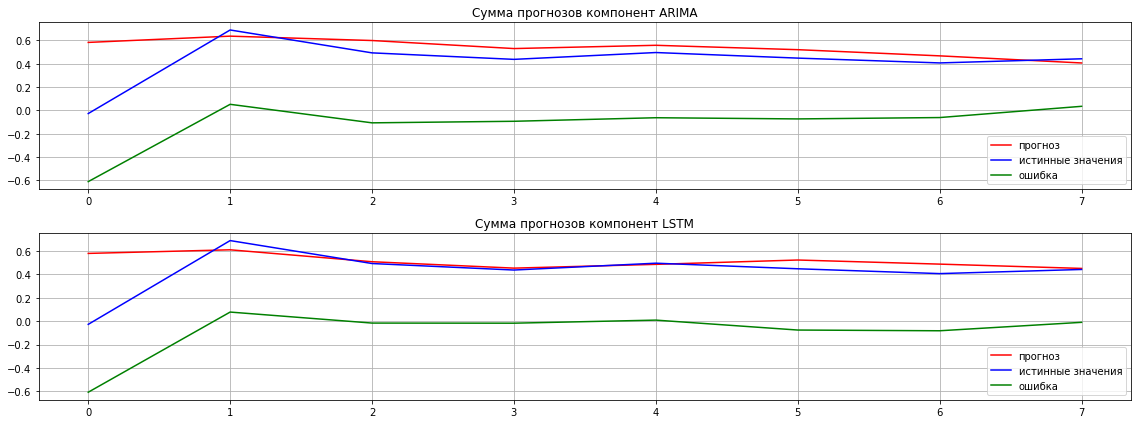

RMSE на норм. данных (ARIMA): 0.22589571621732157
RMSE на норм. данных (LSTM):  0.21990936170932832


In [71]:
# рисуем и печатаем rmse
pict_prov()

    Более точный прогноз, разница rmse 0.6%, несмотря на то, что полученные ранее на валидационных наборах данных результаты говорят в пользу модели ARIMA, получился в случае применения методики LSTM.
    Дополнительно можно сказать, что высокая ошибка в случае применения обоих методов объясняется наличием существенного по величине выброса в значении измерения за неделю с 1 по 7 января 2022 года (праздничные дни, нулевой оборот в продажах).

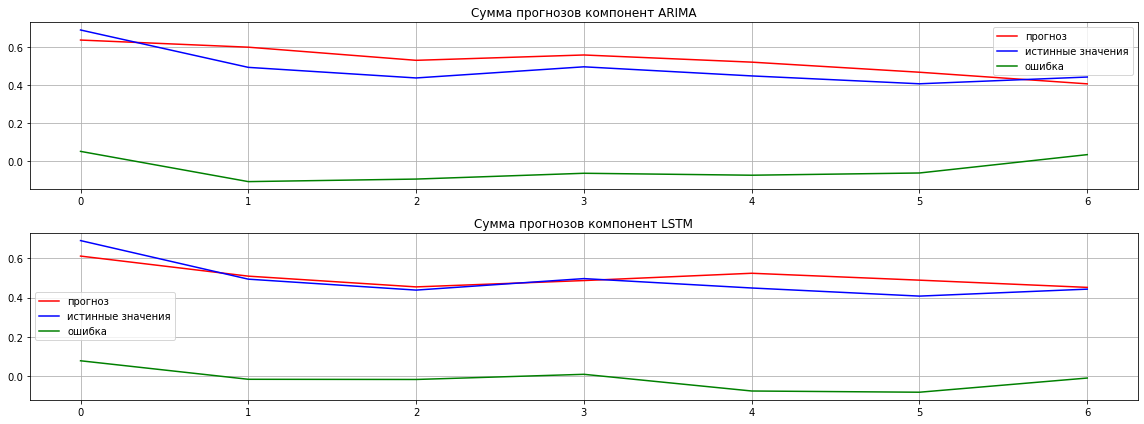

RMSE на норм. данных (ARIMA): 0.07230116469507726
RMSE на норм. данных (LSTM):  0.05220711292226624


In [72]:
# отсеку первое значение прогноза - прогноз на праздничную неделю
pict_prov(1)

    Ошибка сильно снизилась. Разница в прогнозах 2%.
    Полученный прогноз можно взять за ориентир.

* [Содержание](#Table-Of-Contents)

<a id="Conclusion"></a>
# 7. Выводы

    Целью данной дипломной работы является исследование практической применимости статистического метода прогнозирования объемов продаж и получение прогнозных данных об объеме продаж на требуемый период в розничной сети производителя мягкой мебели.
    В работе были использованы реальные данные о продажах за 5 лет работы.
    В ходе работы проведено исследование и подготовка исходного временного ряда для анализа статистическими методами, проанализированы критерии стационарности временного ряда и сделан вывод о его стационарности и, следовательно, готовности к прогнозированию, выдвинута и проверена гипотеза о возможном улучшении качества прогноза в случае обработки временного ряда с предварительным разбиением на составляющие, предложен, реализован и применен метод выделения компонентов исходного временного ряда (SSA), предложены метрики качества модели и прогноза, реализованы 2 метода прогнозирования (ARIMA и LSTM), каждый в варианте без разложения исходного временного ряда на компоненты и с разложением, на основании сравнения результатов прогноза выбран лучший метод и вариант.
    В заключение, составлен прогноз на период 8 недель. Прогноз проверен на реальных данных о продажах за тот же период.
    Основные выводы:
    - методы ARIMA и LSTM дают примерно одинаковое качество прогноза
    - разложение временного ряда на компоненты, с последующим формированием прогноза по каждой компоненте и получением итогового прогноза, как суммы прогнозов компонентов, улучшает качество прогноза по сравнению с прогнозированием по данным исходного временного ряда без разложения на компоненты до 30-40% (на имеющихся данных по продажам)
    - технически LSTM требует больше вычислительных мощностей и работает дольше

    Практическое применение обученных моделей показало, что на имеющихся данных можно достигнуть точности прогноза 6-8% на горизонте планирования 2 месяца.

* [Содержание](#Table-Of-Contents)